In [1]:
import gurobipy as gp
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import re
import shutil

In [2]:
# get input paths
test_set = "miplib_2017_5000"
instance_fldr = os.path.join("instances", test_set)
test_set_fldr = os.path.join("test_sets", test_set)
results_fldr = os.path.join("results", test_set)
out_fldr = os.path.join("outputs", test_set)

# set filters
degrees = [-1, 1]
term_list = [4, 16, 64]
filter_cbc = False

## Check run failures

In [3]:
# check if each folder in test_set_fldr has a corresponding .mps file in instance_fldr
# for instance in os.listdir(test_set_fldr):
#     if not os.path.isdir(os.path.join(test_set_fldr, instance)):
#         continue
#     if not os.path.exists(os.path.join(instance_fldr, f"{instance}.mps")):
#         # remove the folder if the instance is missing
#         shutil.rmtree(os.path.join(test_set_fldr, instance))
#         print(f"Removed {instance} from test set")

In [4]:
# running list of strings contained by different error codes
# last two are catchalls
err = {
    "walltime": [],
    "bad_alloc": [],
    "out of memory": [],
    "takeoffcuts": [],
    "solver is dual infeasible": [],
    "solver must be optimal": [],
    "segmentation fault": [],
    "no vpcs were made from a new disjunction": [],
    "must have primalbound >= root lp objective": [],
    "objective at parent node": [],
    "failed to optimize mip": [],
    "disjunction does not represent a full binary tree": [],
    "nonbasic reduced cost should be": [],
    "solver not proven optimal for node": [],
    "unable to open": [],
    "license": [],
    "dot product with obj differs from solver": [],
    "gurobi: error during callback: addCut": [],
    "cglvpc::setupconstraints: objective at disjunctive term": [],
    "unable to read file": [],
    "stats.id == stats_vec": [],
}

# read in cbc acceptable instances from cbc.txt
with open("cbc.txt", "r") as f:
    cbc_instances = f.read().split("\n")

# runs that errored out with new error code
other = []

# runs that had no errors
empty = []

# runs that only had warnings
warn_strs = ["warning", "prlp is primal infeasible", "farkas", "x:", "x[", "b:",
             "b[", "v:", "v[", "cut:", "A_i . x", "dot product with obj differs from solver"]
warning = []

# series that didn't run
no_go = []

# track sizes of instances
rows, cols = {}, {}

# map the names
names = {}

# counts
count_series = 0
count_instances = 0
number_instances = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    # only look at cbc instances if we ran with cbc
    if instance not in cbc_instances and "gurobi" not in test_set and filter_cbc:
        continue
        
    # get the number of rows and columns in the instance
    mdl = gp.read(os.path.join(instance_fldr, f"{instance}.mps"))
    rows[instance] = mdl.NumConstrs
    cols[instance] = mdl.NumVars
        
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        # only look at perturbations that were run
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:

                # set variables for this iteration
                count_series += 1
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                file_pth = os.path.join(results_fldr, f"{stem}.err")
                series_fldr = os.path.join(test_set_fldr, instance, perturbation)
                current_count = len([f for f in os.listdir(series_fldr) if f.endswith(".mps")])
                count_instances += current_count
                names[stem] = instance
                number_instances[stem] = {
                    "expected": current_count,
                    "recorded": 0,
                    "generator": generator,
                    "error": "N/A"
                }

                # check if the series wasn't run
                if not os.path.exists(file_pth):
                    number_instances[stem]["error"] = "no go"
                    no_go.append(stem)
                
                # check if the series ran with no errors or warnings
                elif os.path.getsize(file_pth) == 0:
                    number_instances[stem]["error"] = "empty"
                    empty.append(stem)
                
                # track which error codes were thrown
                else:
                    # read the file
                    with open(file_pth, "r") as f:
                        text = f.read().lower()
                    
                    # assign the error file to the appropriate list
                    found_code = False
                    for code in err:
                        if code in text:
                            if code == "dot product with obj differs from solver":
                                pattern = r"obj viol from solver: (\d+\.\d+)\. calculated: (\d+\.\d+)"
                                s, c = re.findall(pattern, text)[-1]
                                # if we didn't terminate, this isn't an error, so keep going
                                if abs(float(s) - float(c)) < 1e-3:
                                    continue
                            err[code].append(stem)
                            found_code = True
                            number_instances[stem]["error"] = code
                            break
                    if not found_code:
                        if all(not line or any(w in line for w in warn_strs) for line in text.splitlines()):
                            warning.append(stem)
                            number_instances[stem]["error"] = "warning"
                        else:
                            other.append(stem)
                            number_instances[stem]["error"] = "other"

Set parameter Username
Academic license - for non-commercial use only - expires 2024-08-31
Read MPS format model from file instances/miplib_2017_5000/bienst2.mps
Reading time = 0.00 seconds
bienst2: 576 rows, 505 columns, 2184 nonzeros
Read MPS format model from file instances/miplib_2017_5000/set3-15.mps
Reading time = 0.00 seconds
set3-15: 3747 rows, 4019 columns, 13747 nonzeros
Read MPS format model from file instances/miplib_2017_5000/f2gap801600.mps
Reading time = 0.00 seconds
f2gap801600: 80 rows, 1600 columns, 3200 nonzeros
Read MPS format model from file instances/miplib_2017_5000/stein15inf.mps
Reading time = 0.00 seconds
stein15inf: 37 rows, 15 columns, 135 nonzeros
Read MPS format model from file instances/miplib_2017_5000/neos-3610173-itata.mps
Reading time = 0.00 seconds
neos-3610173-itata: 747 rows, 844 columns, 2130 nonzeros
Read MPS format model from file instances/miplib_2017_5000/10teams.mps
Reading time = 0.00 seconds
10TEAMS: 230 rows, 2025 columns, 12150 nonzeros
R

In [5]:
# check which series didn't run
print(no_go)

['neos-3661949-lesse_objective_-1_16_Farkas']


In [6]:
# get the proportion of series that at least got started
1 - (len(no_go) / count_series)

0.9999368208238565

In [7]:
# out of time - got hung up in code somewhere - ok
print(err["walltime"])
len(err["walltime"]) / count_series

['cod105_objective_1_16_Old', 'cod105_objective_1_64_Farkas', 'cod105_matrix_1_16_New', 'cod105_matrix_1_16_Old', 'cod105_matrix_1_16_Farkas', 'cod105_matrix_1_64_New', 'cod105_matrix_1_64_Old', 'cod105_matrix_1_64_Farkas', 'cod105_matrix_-1_16_New', 'cod105_matrix_-1_16_Old', 'cod105_matrix_-1_16_Farkas', 'cod105_matrix_-1_64_New', 'cod105_matrix_-1_64_Old', 'cod105_matrix_-1_64_Farkas', 'cod105_objective_-1_16_Farkas', 'cod105_objective_-1_64_New', 'cod105_objective_-1_64_Old', 'cod105_bound_1_16_Farkas', 'irp_objective_-1_4_New', 'neos-1601936_rhs_-1_16_New', 'neos-1601936_rhs_-1_16_Farkas', 'neos-1601936_rhs_-1_64_Old', 'neos-1601936_rhs_-1_64_Farkas', 'neos-1601936_bound_-1_16_New', 'neos-1601936_bound_-1_16_Farkas', 'neos-1601936_bound_-1_64_New', 'neos-1601936_bound_-1_64_Old', 'neos-1601936_bound_-1_64_Farkas', 'neos-1601936_objective_-1_64_New', 'neos-1445743_bound_1_4_New', 'neos-1445738_bound_1_4_New']


0.0019585544604498357

In [8]:
# out of memory - memory is maxed already - this is what it is
# todo: figure out where we ran short on memory so we can explain why we dropped them
print(err["bad_alloc"] + err["out of memory"])
len(err["bad_alloc"] + err["out of memory"]) / count_series

['gmu-35-40_objective_-1_64_Old', 'gmu-35-40_objective_-1_64_Farkas', 'neos-585192_objective_1_64_Farkas', 'piperout-d27_objective_1_16_New', 'piperout-d27_objective_1_16_Old', 'piperout-d27_objective_1_16_Farkas', 'piperout-d27_objective_1_64_New', 'piperout-d27_objective_-1_64_New', 'piperout-d27_objective_-1_64_Old', 'piperout-d27_objective_-1_64_Farkas', 'piperout-d20_objective_1_16_New', 'piperout-d20_objective_1_64_New', 'piperout-d20_objective_1_64_Old', 'piperout-d20_objective_1_64_Farkas', 'piperout-d20_objective_-1_16_New', 'piperout-d20_objective_-1_64_New', 'piperout-d20_objective_-1_64_Old', 'piperout-d20_objective_-1_64_Farkas', 'piperout-d20_bound_1_64_New', 'piperout-d20_bound_1_64_Old', 'piperout-d20_bound_1_64_Farkas', 'mine-90-10_objective_1_16_New', 'mine-90-10_objective_1_16_Old', 'mine-90-10_objective_1_16_Farkas', 'mine-90-10_matrix_1_16_Old', 'mine-90-10_matrix_1_16_Farkas', 'mine-90-10_matrix_-1_16_New', 'mine-90-10_matrix_-1_16_Old', 'mine-90-10_matrix_-1_16_F

0.012383118524134444

In [9]:
# bad_alloc_names = set(n.split("_")[0] for n in err["bad_alloc"])
# mem = pd.read_csv("more_memory.csv", index_col=0)
# mem["reason"] = "hard solve" 
# 
# for n in bad_alloc_names:
#     if f"{n}.mps" not in mem.index:
#         new_row = pd.DataFrame([{'file_name': f"{n}.mps", 'memory': 16.0, 'reason': 'big disjunction'}]).set_index('file_name')
#         mem = pd.concat([mem, new_row])
#     else:
#         mem.loc[f'{n}.mps', 'memory'] = 16.0
# 
# mem.to_csv("more_memory.csv")

In [10]:
# this is an issue with John's bookkeeping - not much we can do here
print(err["takeoffcuts"])
len(err["takeoffcuts"]) / count_series

[]


0.0

In [11]:
print(err["solver is dual infeasible"])
len(err["solver is dual infeasible"]) / count_series

[]


0.0

In [12]:
# these are usually issues with CLP finding optimality - not much we can do here
print(err["solver must be optimal"])
len(err["solver must be optimal"]) / count_series

[]


0.0

In [13]:
print(err["segmentation fault"])
len(err["segmentation fault"]) / count_series

[]


0.0

In [14]:
seg_err = {
    "Bad image at line": [],
}

seg_other = []

for stem in err["segmentation fault"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in seg_err:
        if code in text:
            seg_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        seg_other.append(stem)

In [15]:
print(seg_err["Bad image at line"])
len(seg_err["Bad image at line"]) / len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [16]:
print(seg_other)
len(seg_other)/len(err["segmentation fault"]) if err["segmentation fault"] else 0

[]


0

In [17]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning
for code, exps in seg_err.items():
    print(f"{code}: {len(exps) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

print(f"other: {len(seg_other) / len(err['segmentation fault']) if err['segmentation fault'] else 0}")

Bad image at line: 0
other: 0


In [18]:
# these should all be from the problem being too big and hitting the time limit or integer solutions
print(err["no vpcs were made from a new disjunction"])
missing_4_term = [n for n in err["no vpcs were made from a new disjunction"] if "_4_" in n]
missing_64_term = [n for n in err["no vpcs were made from a new disjunction"] if "_64_" in n]
missing_16_term = [n for n in err["no vpcs were made from a new disjunction"] if "_16_" in n]
print(f'4 term: {len(missing_4_term) / count_series}')
print(f'64 term: {len(missing_64_term) / count_series}')
print(f'16 term: {len(missing_16_term) / count_series}')

['bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'f2gap801600_objective_1_64_Farkas', 'f2gap801600_rhs_-1_64_New', 'f2gap801600_rhs_-1_64_Old', 'f2gap801600_rhs_-1_64_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_bound_1_64_New', 'f2gap801600_bound_1_64_Old', 'f2gap801600_bound_1_64_Farkas', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_matrix_1_16_Farkas', 'neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_objective_1_64_

In [19]:
vpc_err = {
    "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: TIME_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_CUTS_LIKELY": [],
    "CglVPC: Finishing with exit reason: PRLP_INFEASIBLE": [],
    "CglVPC: Finishing with exit reason: SUCCESS": [],
    "CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND": [],
    "CglVPC: Finishing with exit reason: FAIL_LIMIT": [],
    "CglVPC: Finishing with exit reason: NO_DISJUNCTION": [],
}

vpc_other = []

for stem in err["no vpcs were made from a new disjunction"]:
    file_pth = os.path.join(results_fldr, f"{stem}.out")

    with open(file_pth, "r") as f:
        text = f.read()
    
    # assign the error file to the appropriate list
    found_code = False
    for code in vpc_err:
        if code in text:
            vpc_err[code].append(stem)
            found_code = True
            break
    if not found_code:
        vpc_other.append(stem)

In [20]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['bienst2_objective_1_64_Farkas', 'bienst2_matrix_-1_64_New', 'bienst2_matrix_-1_64_Old', 'bienst2_objective_-1_64_Farkas', 'f2gap801600_objective_1_64_Farkas', 'f2gap801600_rhs_-1_64_New', 'f2gap801600_rhs_-1_64_Old', 'f2gap801600_rhs_-1_64_Farkas', 'f2gap801600_objective_-1_64_New', 'f2gap801600_objective_-1_64_Old', 'f2gap801600_bound_1_64_New', 'f2gap801600_bound_1_64_Old', 'f2gap801600_bound_1_64_Farkas', '10teams_objective_1_16_Old', '10teams_objective_1_16_Farkas', '10teams_matrix_1_16_Farkas', 'neos-555343_rhs_1_64_New', 'neos-555343_rhs_1_64_Old', 'neos-555343_rhs_1_64_Farkas', 'neos-555343_objective_1_64_New', 'neos-555343_objective_1_64_Old', 'neos-555343_objective_1_64_Farkas', 'neos-555343_matrix_1_64_New', 'neos-555343_matrix_1_64_Old', 'neos-555343_matrix_1_64_Farkas', 'neos-555343_bound_1_64_New', 'neos-555343_bound_1_64_Old', 'neos-555343_bound_1_64_Farkas', 'lrn_objective_1_16_New', 'lrn_objective_1_16_Old', 'lrn_objective_1_16_Farkas', 'lrn_objective_1_64_New', 'lrn_

0.2857557296199594

In [21]:
print(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: TIME_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['ns1208400_rhs_1_16_New', 'ns1208400_rhs_1_16_Old', 'ns1208400_rhs_1_16_Farkas', 'ns1208400_rhs_1_64_New', 'ns1208400_rhs_1_64_Old', 'ns1208400_rhs_1_64_Farkas', 'ns1208400_objective_1_16_Old', 'ns1208400_objective_1_64_New', 'ns1208400_objective_1_64_Old', 'ns1208400_objective_1_64_Farkas', 'ns1208400_matrix_1_16_New', 'ns1208400_matrix_1_16_Old', 'ns1208400_matrix_1_16_Farkas', 'ns1208400_matrix_1_64_New', 'ns1208400_matrix_1_64_Farkas', 'ns1208400_matrix_-1_16_New', 'ns1208400_matrix_-1_16_Old', 'ns1208400_matrix_-1_16_Farkas', 'ns1208400_matrix_-1_64_New', 'ns1208400_objective_-1_16_New', 'ns1208400_objective_-1_16_Old', 'ns1208400_objective_-1_16_Farkas', 'ns1208400_objective_-1_64_New', 'ns1208400_objective_-1_64_Old', 'ns1208400_objective_-1_64_Farkas', 'ns1208400_bound_1_16_New', 'ns1208400_bound_1_16_Old', 'ns1208400_bound_1_16_Farkas', 'neos-691058_rhs_1_64_New', 'neos-691058_rhs_1_64_Old', 'neos-691058_rhs_1_64_Farkas', 'neos-691058_objective_1_64_New', 'neos-691058_objecti

0.05802146794313896

In [22]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_CUTS_LIKELY"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_4_New', 'neos-555343_rhs_1_4_Old', 'neos-555343_rhs_1_4_Farkas', 'neos-555343_objective_1_4_New', 'neos-555343_objective_1_4_Old', 'neos-555343_objective_1_4_Farkas', 'neos-555343_matrix_1_4_New', 'neos-555343_matrix_1_4_Old', 'neos-555343_matrix_1_4_Farkas', 'neos-555343_bound_1_4_New', 'neos-555343_bound_1_4_Old', 'neos-555343_bound_1_4_Farkas', 'pigeon-20_matrix_1_4_New', 'pigeon-20_matrix_1_4_Farkas', 'pigeon-20_bound_1_4_New', 'pigeon-20_bound_1_4_Farkas', 'neos-1171737_objective_1_4_New', 'neos-1171737_objective_1_4_Old', 'neos-1171737_objective_1_4_Farkas', 'neos-1171737_objective_1_16_New', 'neos-1171737_objective_1_16_Old', 'neos-1171737_objective_1_16_Farkas', 'neos-1171737_objective_1_64_New', 'neos-1171737_objective_1_64_Old', 'neos-1171737_objective_1_64_Farkas', 'neos-1171737_matrix_1_4_New', 'neos-1171737_matrix_1_4_Old', 'neos-1171737_matrix_1_4_Farkas', 'neos-1171737_matrix_1_16_New', 'neos-1171737_matrix_1_16_Old', 'neos-1171737_matrix_1_16_Farkas'

0.323179576443284

In [23]:
print(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"])
len(vpc_err["CglVPC: Finishing with exit reason: PRLP_INFEASIBLE"]) / len(err["no vpcs were made from a new disjunction"])

['neos-555343_rhs_1_16_New', 'neos-555343_rhs_1_16_Old', 'neos-555343_rhs_1_16_Farkas', 'neos-555343_objective_1_16_New', 'neos-555343_objective_1_16_Old', 'neos-555343_objective_1_16_Farkas', 'neos-555343_matrix_1_16_New', 'neos-555343_matrix_1_16_Old', 'neos-555343_matrix_1_16_Farkas', 'neos-555343_bound_1_16_New', 'neos-555343_bound_1_16_Old', 'neos-555343_bound_1_16_Farkas', 'pigeon-20_rhs_1_64_New', 'pigeon-20_objective_1_16_New', 'pigeon-20_objective_1_16_Farkas', 'pigeon-20_objective_1_64_Farkas', 'pigeon-20_rhs_-1_64_Farkas', 'pigeon-20_bound_-1_16_New', 'pigeon-20_bound_-1_16_Old', 'pigeon-20_bound_-1_64_New', 'pigeon-20_objective_-1_16_Old', 'pigeon-20_objective_-1_16_Farkas', 'pigeon-20_objective_-1_64_Farkas', 'pigeon-20_bound_1_64_Old', 'pigeon-20_bound_1_64_Farkas', 'graphdraw-domain_rhs_1_64_New', 'graphdraw-domain_rhs_1_64_Old', 'graphdraw-domain_rhs_1_64_Farkas', 'graphdraw-domain_objective_1_64_New', 'graphdraw-domain_objective_1_64_Old', 'graphdraw-domain_objective_1

0.14998549463301422

In [24]:
print(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"])
len(vpc_err["CglVPC: Finishing with exit reason: SUCCESS"]) / len(err["no vpcs were made from a new disjunction"])

['neos-1112787_matrix_-1_16_Old', 'neos-1112787_bound_1_4_New', 'neos-1112787_bound_1_16_Farkas', 'neos-1112782_objective_1_4_Farkas', 'neos-1112782_objective_1_16_New', 'neos-3592146-hawea_objective_-1_64_Farkas']


0.0017406440382941688

In [25]:
print(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"])
len(vpc_err["CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND"]) / len(err["no vpcs were made from a new disjunction"])

['tanglegram6_objective_1_16_New', 'tanglegram6_objective_1_16_Old', 'tanglegram6_objective_1_16_Farkas', 'tanglegram6_objective_1_64_New', 'tanglegram6_objective_1_64_Old', 'tanglegram6_objective_1_64_Farkas', 'tanglegram6_matrix_1_16_New', 'tanglegram6_matrix_1_16_Old', 'tanglegram6_matrix_1_16_Farkas', 'tanglegram6_matrix_1_64_New', 'tanglegram6_matrix_1_64_Old', 'tanglegram6_matrix_1_64_Farkas', 'tanglegram6_objective_-1_16_New', 'tanglegram6_objective_-1_16_Old', 'tanglegram6_objective_-1_16_Farkas', 'tanglegram6_objective_-1_64_New', 'tanglegram6_objective_-1_64_Old', 'tanglegram6_objective_-1_64_Farkas', 'mod010_objective_1_16_New', 'mod010_objective_1_64_New', 'mod010_matrix_1_16_Old', 'mod010_bound_1_16_Old', 'f2gap40400_objective_1_4_New', 'f2gap40400_objective_1_4_Old', 'f2gap40400_objective_1_4_Farkas', 'f2gap40400_objective_1_16_New', 'f2gap40400_objective_1_16_Old', 'f2gap40400_objective_1_16_Farkas', 'f2gap40400_objective_1_64_New', 'f2gap40400_objective_1_64_Old', 'f2ga

0.10240789091964027

In [26]:
print(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"])
len(vpc_err["CglVPC: Finishing with exit reason: FAIL_LIMIT"]) / len(err["no vpcs were made from a new disjunction"])

['lrn_objective_-1_4_Farkas', 'mine-90-10_matrix_-1_4_New', 'mine-90-10_matrix_-1_4_Old', 'mine-90-10_matrix_-1_4_Farkas', 'mine-90-10_objective_-1_4_New', 'mine-90-10_objective_-1_4_Old', 'mine-90-10_objective_-1_4_Farkas', 'neos-3734794-moppy_objective_1_16_New', 'neos-3734794-moppy_objective_1_16_Old', 'neos-3734794-moppy_objective_1_16_Farkas', 'neos-3734794-moppy_matrix_1_16_New', 'neos-3734794-moppy_matrix_1_16_Old', 'neos-3734794-moppy_matrix_1_16_Farkas', 'neos-3734794-moppy_matrix_-1_16_New', 'neos-3734794-moppy_matrix_-1_16_Old', 'neos-3734794-moppy_matrix_-1_16_Farkas', 'neos-3734794-moppy_objective_-1_16_New', 'neos-3734794-moppy_objective_-1_16_Old', 'neos-3734794-moppy_objective_-1_16_Farkas', 'neos-3734794-moppy_bound_1_16_New', 'neos-3734794-moppy_bound_1_16_Old', 'neos-3734794-moppy_bound_1_16_Farkas', 'milo-v12-6-r2-40-1_objective_1_4_New', 'milo-v12-6-r2-40-1_objective_1_4_Old', 'milo-v12-6-r2-40-1_objective_1_4_Farkas', 'milo-v12-6-r2-40-1_objective_1_16_New', 'milo

0.015375689004931825

In [27]:
print(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"])
len(vpc_err["CglVPC: Finishing with exit reason: NO_DISJUNCTION"]) / len(err["no vpcs were made from a new disjunction"])

['rentacar_objective_1_16_New', 'rentacar_objective_1_16_Old', 'rentacar_objective_1_16_Farkas', 'rentacar_matrix_-1_16_New', 'rentacar_matrix_-1_16_Old', 'rentacar_matrix_-1_16_Farkas', 'rentacar_objective_-1_16_New', 'rentacar_objective_-1_16_Old', 'rentacar_objective_-1_16_Farkas', 'supportcase26_rhs_1_16_New', 'supportcase26_rhs_1_16_Old', 'supportcase26_rhs_1_16_Farkas', 'supportcase26_rhs_1_64_New', 'supportcase26_rhs_1_64_Old', 'supportcase26_rhs_1_64_Farkas', 'supportcase26_objective_1_16_New', 'supportcase26_objective_1_16_Old', 'supportcase26_objective_1_16_Farkas', 'supportcase26_objective_1_64_New', 'supportcase26_objective_1_64_Old', 'supportcase26_objective_1_64_Farkas', 'supportcase26_rhs_-1_16_New', 'supportcase26_rhs_-1_16_Old', 'supportcase26_rhs_-1_16_Farkas', 'supportcase26_rhs_-1_64_New', 'supportcase26_rhs_-1_64_Old', 'supportcase26_rhs_-1_64_Farkas', 'supportcase26_matrix_-1_16_New', 'supportcase26_matrix_-1_16_Old', 'supportcase26_matrix_-1_16_Farkas', 'supportc

0.06208297069915869

In [28]:
vpc_other

['neos-1442119_matrix_-1_64_New',
 'mappingmesh3x3mpeg2i_objective_1_16_Farkas',
 'neos-3083784-nive_bound_1_16_New',
 'neos-2657525-crna_matrix_-1_4_Old',
 'neos-2657525-crna_matrix_-1_4_Farkas']

In [29]:
# get breakdown of why vpc generation failed - mostly from lack of provisioning/problem being too large
for code, exps in vpc_err.items():
    print(f"{code}: {len(exps) / len(err['no vpcs were made from a new disjunction'])}")

print(f"other: {len(vpc_other) / len(err['no vpcs were made from a new disjunction'])}")

CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT: 0.2857557296199594
CglVPC: Finishing with exit reason: TIME_LIMIT: 0.05802146794313896
CglVPC: Finishing with exit reason: NO_CUTS_LIKELY: 0.323179576443284
CglVPC: Finishing with exit reason: PRLP_INFEASIBLE: 0.14998549463301422
CglVPC: Finishing with exit reason: SUCCESS: 0.0017406440382941688
CglVPC: Finishing with exit reason: OPTIMAL_SOLUTION_FOUND: 0.10240789091964027
CglVPC: Finishing with exit reason: FAIL_LIMIT: 0.015375689004931825
CglVPC: Finishing with exit reason: NO_DISJUNCTION: 0.06208297069915869
other: 0.001450536698578474


In [30]:
# todo: figure this out
print(err["must have primalbound >= root lp objective"])
len(err["must have primalbound >= root lp objective"]) / count_series

['neos4_objective_-1_4_None', 'neos4_objective_-1_16_None', 'neos4_objective_-1_64_None', 'neos-3048764-nadi_objective_1_4_None', 'neos-3048764-nadi_objective_1_4_New', 'neos-3048764-nadi_objective_1_4_Old', 'neos-3048764-nadi_objective_1_4_Farkas', 'neos-3048764-nadi_objective_1_16_None', 'neos-3048764-nadi_objective_1_16_New', 'neos-3048764-nadi_objective_1_16_Old', 'neos-3048764-nadi_objective_1_16_Farkas', 'neos-3048764-nadi_objective_1_64_None', 'neos-3048764-nadi_objective_1_64_New', 'neos-3048764-nadi_objective_1_64_Old', 'neos-3048764-nadi_objective_1_64_Farkas', 'neos-3048764-nadi_matrix_1_4_Old', 'neos-3048764-nadi_matrix_1_16_Old', 'neos-3048764-nadi_matrix_1_16_Farkas', 'neos-3048764-nadi_matrix_1_64_None', 'neos-3048764-nadi_matrix_1_64_New', 'neos-3048764-nadi_matrix_1_64_Farkas', 'neos-3048764-nadi_rhs_-1_4_None', 'neos-3048764-nadi_rhs_-1_4_New', 'neos-3048764-nadi_rhs_-1_4_Old', 'neos-3048764-nadi_rhs_-1_4_Farkas', 'neos-3048764-nadi_rhs_-1_16_None', 'neos-3048764-nadi

0.0035380338640384128

In [31]:
# LP relaxation objective is not going to match root node objective when warm starting 
print(err["objective at parent node"])
len(err["objective at parent node"]) / count_series

[]


0.0

In [32]:
# not enough tolerance added to bound (or we hit time limit) - element 2 from 5 and 4 from 4
# todo handle this gracefully
print(err["failed to optimize mip"])
len(err["failed to optimize mip"]) / count_series

['markshare_5_0_matrix_1_4_None', 'markshare_5_0_matrix_1_16_None', 'markshare_5_0_matrix_1_64_None', 'markshare_4_0_matrix_1_4_None', 'markshare_4_0_matrix_1_16_None', 'markshare_4_0_matrix_1_64_None']


0.0003790750568612585

In [33]:
# todo: figure out why
print(err["disjunction does not represent a full binary tree"])
len(err["disjunction does not represent a full binary tree"]) / count_series

['nu25-pr12_bound_1_64_New']


6.317917614354308e-05

In [34]:
# this and next issue I think are because we run out of time creating tree leading to errors - no longer replicating
# todo: handle gracefully 
print(err["nonbasic reduced cost should be"])
len(err["nonbasic reduced cost should be"]) / count_series

['neos-3610173-itata_matrix_-1_64_New', 'gmu-35-40_objective_1_4_Old', 'gmu-35-40_matrix_-1_64_New', 'gmu-35-40_objective_-1_4_New', 'gmu-35-40_objective_-1_4_Old', 'gmu-35-40_objective_-1_4_Farkas', 'gmu-35-40_objective_-1_16_New', 'gmu-35-40_objective_-1_16_Old', 'gmu-35-40_objective_-1_64_New', 'ci-s4_objective_-1_64_New', 'neos-3611447-jijia_matrix_-1_64_Old', 'sp150x300d_objective_1_4_New', 'sp150x300d_objective_1_4_Old', 'sp150x300d_objective_1_4_Farkas', 'sp150x300d_objective_1_16_New', 'sp150x300d_objective_1_16_Old', 'sp150x300d_objective_1_16_Farkas', 'sp150x300d_objective_1_64_New', 'sp150x300d_objective_1_64_Old', 'sp150x300d_objective_1_64_Farkas', 'sp150x300d_matrix_1_4_New', 'sp150x300d_matrix_1_4_Old', 'sp150x300d_matrix_1_4_Farkas', 'sp150x300d_matrix_1_16_New', 'sp150x300d_matrix_1_16_Old', 'sp150x300d_matrix_1_16_Farkas', 'sp150x300d_matrix_1_64_New', 'sp150x300d_matrix_1_64_Old', 'sp150x300d_matrix_1_64_Farkas', 'sp150x300d_matrix_-1_4_New', 'sp150x300d_matrix_-1_4_

0.007897397017942885

In [35]:
# again issue with not getting through vpc generation in time
# todo: handle this gracefully
print(err["solver not proven optimal for node"])
len(err["solver not proven optimal for node"]) / count_series

[]


0.0

In [36]:
print(err["unable to open"])
len(err["unable to open"]) / count_series

[]


0.0

In [37]:
print(err["license"])
len(err["license"]) / count_series

[]


0.0

In [38]:
print(warning)
len(warning) / count_series

['bienst2_rhs_1_4_New', 'bienst2_rhs_1_16_Old', 'bienst2_rhs_1_64_New', 'bienst2_rhs_1_64_Old', 'bienst2_rhs_1_64_Farkas', 'bienst2_objective_1_4_New', 'bienst2_objective_1_16_Old', 'bienst2_objective_1_64_New', 'bienst2_objective_1_64_Old', 'bienst2_matrix_-1_4_New', 'bienst2_matrix_-1_16_New', 'bienst2_matrix_-1_16_Old', 'bienst2_matrix_-1_64_Farkas', 'bienst2_objective_-1_16_New', 'bienst2_objective_-1_16_Old', 'bienst2_objective_-1_64_New', 'bienst2_objective_-1_64_Old', 'f2gap801600_objective_1_16_Old', 'f2gap801600_rhs_-1_16_New', 'f2gap801600_rhs_-1_16_Old', 'f2gap801600_rhs_-1_16_Farkas', 'f2gap801600_objective_-1_16_New', 'f2gap801600_objective_-1_16_Farkas', 'f2gap801600_bound_1_16_New', 'f2gap801600_bound_1_16_Old', 'f2gap801600_bound_1_16_Farkas', 'neos-3610173-itata_objective_-1_4_Old', '10teams_bound_1_4_Old', 'gmu-35-40_matrix_-1_16_Old', 'neos-3610051-istra_objective_1_4_Old', 'neos-3610051-istra_objective_1_16_New', 'neos-3610051-istra_rhs_-1_4_Old', 'neos-3610051-istr

0.05079605761940864

In [39]:
# errors unaccounted for
print(other)
len(other) / count_series

['traininstance6_rhs_-1_4_Old', 'piperout-d20_objective_-1_16_Old', 'piperout-d20_objective_-1_16_Farkas', 'piperout-d20_bound_1_16_New', 'supportcase27i_objective_1_16_New', 'supportcase27i_objective_1_16_Old', 'supportcase27i_objective_-1_4_Old', 'supportcase27i_objective_-1_16_New', 'supportcase27i_objective_-1_16_Old', 'lectsched-4-obj_matrix_-1_16_Old', 'eil33-2_objective_1_4_New', 'neos16_rhs_1_4_New', 'neos16_rhs_1_4_Old', 'neos16_rhs_1_4_Farkas', 'neos16_rhs_1_16_New', 'neos16_rhs_1_16_Farkas', 'neos16_matrix_1_16_Farkas', 'neos16_matrix_-1_4_New', 'neos16_matrix_-1_16_Farkas', 'neos-1445765_bound_1_4_New', 'supportcase25_bound_1_64_New', 'glass4_objective_1_64_New']


0.0013899418751579479

In [40]:
# proportion of series that were improperly provisioned
(len(err["bad_alloc"] + err["out of memory"] + err["walltime"])) / count_series

0.01434167298458428

In [41]:
# todo handle this
print(err["dot product with obj differs from solver"])
len(err["dot product with obj differs from solver"]) / count_series

['traininstance6_objective_1_16_Old', 'traininstance6_rhs_-1_16_Old', 'traininstance6_matrix_-1_16_Old', 'traininstance6_objective_-1_16_Old', 'neos-3734794-moppy_matrix_-1_4_New', 'neos-3734794-moppy_matrix_-1_4_Old', 'neos-3592146-hawea_matrix_-1_4_New', 'neos-3592146-hawea_matrix_-1_16_New', 'neos-3592146-hawea_matrix_-1_64_New', 'neos-3592146-hawea_matrix_-1_64_Old', 'neos-3592146-hawea_objective_-1_16_New', 'glass4_matrix_-1_64_Old']


0.000758150113722517

In [42]:
# changed code to ignore this error
print(err["gurobi: error during callback: addCut"])
len(err["gurobi: error during callback: addCut"]) / count_series

[]


0.0

In [43]:
# not replicating - rerun
print(err["cglvpc::setupconstraints: objective at disjunctive term"])
len(err["cglvpc::setupconstraints: objective at disjunctive term"]) / count_series

['neos-574665_matrix_-1_64_New', 'traininstance6_objective_-1_4_New', 'traininstance6_objective_-1_16_New', 'neos-3083819-nubu_rhs_1_16_New', 'neos-3083819-nubu_rhs_1_16_Old', 'neos-3083819-nubu_rhs_1_16_Farkas', 'neos-3083819-nubu_rhs_1_64_New', 'neos-3083819-nubu_rhs_1_64_Old', 'neos-3083819-nubu_rhs_1_64_Farkas', 'neos-3083819-nubu_objective_1_16_New', 'neos-3083819-nubu_objective_1_16_Old', 'neos-3083819-nubu_objective_1_16_Farkas', 'neos-3083819-nubu_objective_1_64_New', 'neos-3083819-nubu_objective_1_64_Old', 'neos-3083819-nubu_objective_1_64_Farkas', 'neos-3083819-nubu_matrix_1_16_New', 'neos-3083819-nubu_matrix_1_16_Old', 'neos-3083819-nubu_matrix_1_16_Farkas', 'neos-3083819-nubu_matrix_1_64_New', 'neos-3083819-nubu_matrix_1_64_Old', 'neos-3083819-nubu_matrix_1_64_Farkas', 'neos-3083819-nubu_matrix_-1_16_New', 'neos-3083819-nubu_matrix_-1_16_Old', 'neos-3083819-nubu_matrix_-1_16_Farkas', 'neos-3083819-nubu_matrix_-1_64_New', 'neos-3083819-nubu_matrix_-1_64_Old', 'neos-3083819-n

0.00347485468789487

In [44]:
# not replicating - rerun
print(err["unable to read file"])
len(err["unable to read file"]) / count_series

['neos-1396125_objective_1_4_New', 'neos-1396125_objective_1_4_Old', 'neos-1396125_objective_-1_4_New', 'neos-1396125_objective_-1_4_Old', 'neos-1396125_objective_-1_4_Farkas', 'maxgasflow_objective_-1_16_Old', 'exp-1-500-5-5_objective_-1_64_Old', 'lectsched-4-obj_rhs_-1_64_Old', 'sp98ir_matrix_-1_16_New', 'sp98ir_bound_1_16_New', 'neos2_objective_1_16_New', 'neos2_rhs_-1_64_Farkas', 'neos2_matrix_-1_64_New', 'blp-ir98_objective_1_64_New', 'blp-ir98_matrix_1_16_New', 'gen-ip002_rhs_-1_64_None', 'neos-1599274_rhs_1_16_Old', 'bnatt400_objective_-1_4_Old', 'gmu-35-50_objective_1_64_New', 'gmu-35-50_matrix_1_16_Old']


0.0012635835228708618

In [45]:
# not replicating - rerun
print(err["stats.id == stats_vec"])
len(err["stats.id == stats_vec"]) / count_series

['irp_objective_1_64_New', 'irp_objective_1_64_Old', 'irp_objective_1_64_Farkas', 'irp_matrix_1_64_New', 'irp_matrix_1_64_Old', 'irp_matrix_1_64_Farkas', 'irp_bound_-1_64_New', 'irp_bound_-1_64_Old', 'irp_bound_-1_64_Farkas', 'irp_matrix_-1_64_New', 'irp_matrix_-1_64_Old', 'irp_matrix_-1_64_Farkas', 'irp_objective_-1_64_New', 'irp_objective_-1_64_Old', 'irp_objective_-1_64_Farkas']


0.0009476876421531463

In [46]:
# get breakdown of errors
for code, exps in err.items():
    print(f"{code}: {len(exps) / count_series}")

print(f"other: {len(other) / count_series}")

print(f"warning: {len(warning) / count_series}")

print(f"no errors/warnings: {len(empty) / count_series}")

print(f"no go: {len(no_go) / count_series}")

walltime: 0.0019585544604498357
bad_alloc: 0.012004043467273186
out of memory: 0.0003790750568612585
takeoffcuts: 0.0
solver is dual infeasible: 0.0
solver must be optimal: 0.0
segmentation fault: 0.0
no vpcs were made from a new disjunction: 0.21777862016679303
must have primalbound >= root lp objective: 0.0035380338640384128
objective at parent node: 0.0
failed to optimize mip: 0.0003790750568612585
disjunction does not represent a full binary tree: 6.317917614354308e-05
nonbasic reduced cost should be: 0.007897397017942885
solver not proven optimal for node: 0.0
unable to open: 0.0
license: 0.0
dot product with obj differs from solver: 0.000758150113722517
gurobi: error during callback: addCut: 0.0
cglvpc::setupconstraints: objective at disjunctive term: 0.00347485468789487
unable to read file: 0.0012635835228708618
stats.id == stats_vec: 0.0009476876421531463
other: 0.0013899418751579479
no errors/warnings: 0.6973085670962851
no go: 6.317917614354308e-05


## Read in data

In [47]:
# map generator names to the corresponding data frames
df_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
gap_map = {
    "None": pd.DataFrame(),
    "Farkas": pd.DataFrame(),
    "New": pd.DataFrame(),
    "Old": pd.DataFrame()
}
regex = re.compile(r'([a-zA-Z0-9-]+(?:_o)?)_([a-z]+)_([0-9-]+)_([0-9]+)_([a-zA-Z ]+)')

# declaring types as needed
column_types = {
    "lpBound": float,
    "lpBoundPostVpc": float,
    "disjunctiveDualBound": float,
    "primalBound": float,
    "rootDualBound": float,
    "dualBound": float
}

skipped_instances = set()

# iterate over all files in the folder
for file_name in os.listdir(results_fldr):
    
    file_pth = os.path.join(results_fldr, file_name)
    
    # if the file is not a nonempty csv, skip it
    if not file_name.endswith(".csv") or os.path.getsize(file_pth) == 0:
        continue
    
    # get the experimental set up
    match = regex.search(file_name)
    instance_name = names.get(file_name[:-4])
    if not instance_name:
        skipped_instances.add(file_name[:-4].split("_")[0])
        os.remove(file_pth)
        continue
    perturbation = match.group(2)
    degree = 2**int(match.group(3))
    terms = int(match.group(4))
    generator = match.group(5)
    primal_bounds = {}
    
    # get the primal bounds for this experiment
    cur_instance_test_set_fldr = os.path.join(test_set_fldr, instance_name, f"{perturbation}_{int(match.group(3))}")
    for test_set_file in os.listdir(cur_instance_test_set_fldr):
        if test_set_file.endswith(".pb"):
            with open(os.path.join(cur_instance_test_set_fldr, test_set_file), "r") as f:
                primal_bounds[".".join(test_set_file.split(".")[:-1])] = float(f.read())
        
    # read the file
    df = pd.read_csv(file_pth, keep_default_na=False, dtype=column_types, index_col=0)
    
    # need to map instanceIndex to stem for querying primal bounds
    stem_map = {
        i: stem for i, stem in enumerate(
            sorted({".".join(test_set_file.split(".")[:-1]) for test_set_file in os.listdir(cur_instance_test_set_fldr)})
        )
    }
    
    for instance_idx in df.index:
        
        # fill in primal bounds if missing
        # df.loc[instance_idx, "primalBound"] = min(primal_bounds.get(stem_map.get(instance_idx), 1e100), df.loc[instance_idx, "primalBound"])
        df.loc[instance_idx, "primalBound"] = min(primal_bounds[stem_map[instance_idx]], df.loc[instance_idx, "primalBound"])
        
        # same with root dual bound
        df.loc[instance_idx, "rootDualBound"] = df.loc[instance_idx, "rootDualBound"] if df.loc[instance_idx, "rootDualBound"] < 1e100 else df.loc[instance_idx, "lpBoundPostVpc"] 
    
    # get rid of the index so the rest of the notebook works
    df.reset_index(inplace=True)
    
    # add some identifying columns
    df["instance"] = instance_name
    df["perturbation"] = perturbation
    df["degree"] = degree
    df["terms"] = terms
    
    # append to the appropriate data frame
    df_map[generator] = pd.concat([df_map[generator], df])
    
    # track recorded vs expected experiments
    number_instances[file_name[:-4]]["recorded"] = len(df)

In [48]:
# convert number_instances to dataframe
frame = pd.DataFrame(number_instances).T
frame

,expected,recorded,generator,error
bienst2_rhs_1_4_None,6,6,None,empty
bienst2_rhs_1_4_New,6,6,New,warning
bienst2_rhs_1_4_Old,6,6,Old,empty
bienst2_rhs_1_4_Farkas,6,6,Farkas,empty
bienst2_rhs_1_16_None,6,6,None,empty
...,...,...,...,...
shipschedule6shipsmixi_bound_1_16_Farkas,6,0,Farkas,empty
shipschedule6shipsmixi_bound_1_64_None,6,0,None,empty
shipschedule6shipsmixi_bound_1_64_New,6,0,New,no vpcs were made from a new disjunction
shipschedule6shipsmixi_bound_1_64_Old,6,0,Old,empty


In [49]:
# redo the runs that have incomplete data that we're not sure should be that way
redos = frame.loc[(frame["expected"] > frame["recorded"]) & (frame["error"] != "no vpcs were made from a new disjunction")].index.tolist()
redos = pd.DataFrame({"experiment": redos})
redos.to_csv("redos.csv", index=False)

In [50]:
# group frame by generator and sum remaining columns
gb = frame.groupby(["generator", "error"]).sum()
gb["ratio"] = gb["recorded"] / gb["expected"]
gb.to_csv(os.path.join(out_fldr, "missing_table.csv"), index=False, mode="w")
gb

expected  \
generator error                                                         
Farkas    bad_alloc                                               532   
          cglvpc::setupconstraints: objective at disjunct...       60   
          empty                                                 12825   
          must have primalbound >= root lp objective               75   
          no go                                                     6   
          no vpcs were made from a new disjunction               5495   
          nonbasic reduced cost should be                         101   
          other                                                    31   
          out of memory                                            20   
          stats.id == stats_vec                                    27   
          unable to read file                                      10   
          walltime                                                 34   
          warning                                                 581   
New       bad_alloc                                               170   
          cglvpc::setupconstraints: objective at disjunct...       74   
          disjunction does not represent a full binary tree         5   
          dot product with obj differs from solver                 23   
          empty                                                 11865   
          must have primalbound >= root lp objective               69   
          no vpcs were made from a new disjunction               5403   
          nonbasic reduced cost should be                         288   
          other                                                    69   
          out of memory                                            11   
          stats.id == stats_vec                                    27   
          unable to read file                                      56   
          walltime                                                 42   
          warning                                                1695   
None      empty                                                 19677   
          failed to optimize mip                                   21   
          must have primalbound >= root lp objective               94   
          unable to read file                                       5   
Old       bad_alloc                                               517   
          cglvpc::setupconstraints: objective at disjunct...       60   
          dot product with obj differs from solver                 39   
          empty                                                 11413   
          must have primalbound >= root lp objective               75   
          no vpcs were made from a new disjunction               5352   
          nonbasic reduced cost should be                         295   
          other                                                    55   
          out of memory                                            10   
          stats.id == stats_vec                                    27   
          unable to read file                                      54   
          walltime                                                 28   
          warning                                                1872   

                                                             recorded  \
generator error                                                         
Farkas    bad_alloc                                               218   
          cglvpc::setupconstraints: objective at disjunct...       10   
          empty                                                  6368   
          must have primalbound >= root lp objective                0   
          no go                                                     0   
          no vpcs were made from a new disjunction                  0   
          nonbasic reduced cost should be                         101   
          other                              

In [52]:
for gen in ["None", "New", "Old", "Farkas"]:
    masks = {
        0: -1e20 > df_map[gen]["lpBound"],
        1: df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"],
        2: (df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas"),
        3: df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"],
        4: (df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3),
        5: df_map[gen]["primalBound"] > 1e20,
        6: 0 > df_map[gen]["vpcGenerationTime"],
        7: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"],
        8: df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"],
        9: df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"],
        10: df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"]
    }
    for i, mask in masks.items():
        print(f"{gen} {i}: {mask.sum() / len(df_map[gen])}")

None 0: 0.0
None 1: 0.0
None 2: 0.0
None 3: 0.0
None 4: 0.0
None 5: 0.0
None 6: 0.0
None 7: 0.0
None 8: 0.0
None 9: 0.0
None 10: 0.0
New 0: 0.0
New 1: 0.0
New 2: 0.0
New 3: 0.0
New 4: 0.0
New 5: 0.0
New 6: 0.0
New 7: 0.0
New 8: 0.0
New 9: 0.0
New 10: 0.0
Old 0: 0.0
Old 1: 0.0
Old 2: 0.0
Old 3: 0.0
Old 4: 0.0
Old 5: 0.0
Old 6: 0.0
Old 7: 0.0
Old 8: 0.0
Old 9: 0.0
Old 10: 0.0
Farkas 0: 0.0
Farkas 1: 0.0
Farkas 2: 0.0
Farkas 3: 0.0
Farkas 4: 0.0
Farkas 5: 0.0
Farkas 6: 0.0
Farkas 7: 0.0
Farkas 8: 0.0
Farkas 9: 0.0
Farkas 10: 0.0


In [53]:
# it shouldn't be possible that dual bound > primal bound. this only happens when we use the saved primal bound, which was used to set the dual bound
df_map[gen][masks[0]]

,instanceIndex,vpcGenerator,terms,lpBound,disjunctiveDualBound,lpBoundPostVpc,rootDualBound,dualBound,primalBound,vpcGenerationTime,...,iterations,maxTime,actualTerms,numCuts,cutLimit,mipSolver,providePrimalBound,instance,perturbation,degree


In [54]:
for gen in df_map:
    mask = (-1e20 > df_map[gen]["lpBound"]) | \
        (df_map[gen]["lpBound"] - 1e-3 > df_map[gen]["lpBoundPostVpc"]) | \
        ((df_map[gen]["lpBoundPostVpc"] - 1e-3 > df_map[gen]["disjunctiveDualBound"]) & (gen != "Farkas")) | \
        (df_map[gen]["rootDualBound"] - 1e-3 > df_map[gen]["dualBound"]) | \
        ((df_map[gen]["dualBound"] - 1e-3 > df_map[gen]["primalBound"]) & (df_map[gen]["dualBound"] / df_map[gen]["primalBound"] > 1 + 1e-3)) | \
        (df_map[gen]["primalBound"] > 1e20) | \
        (0 > df_map[gen]["vpcGenerationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["rootDualBoundTime"]) | \
        (df_map[gen]["rootDualBoundTime"] - 1e-3 > df_map[gen]["terminationTime"]) | \
        (df_map[gen]["vpcGenerationTime"] - 1e-3 > df_map[gen]["bestSolutionTime"]) | \
        (df_map[gen]["bestSolutionTime"] - 1e-3 > df_map[gen]["terminationTime"])
    print(f"{gen}: {mask.sum() / len(df_map[gen])}")
    df_map[gen] = df_map[gen][~mask]

None: 0.0
Farkas: 0.0
New: 0.0
Old: 0.0


In [55]:
# merge the 4 different data frames into one
join_cols = ["instance", "perturbation", "degree", "terms", "instanceIndex"]
df = df_map["None"].merge(df_map["New"], on=join_cols,
                                suffixes=(" None", None))
df = df.merge(df_map["Old"], on=join_cols,
                          suffixes=(" New", None))
df = df.merge(df_map["Farkas"], on=join_cols,
                          suffixes=(" Old", " Farkas"))
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,bestSolutionTime Farkas,terminationTime Farkas,nodes Farkas,iterations Farkas,maxTime Farkas,actualTerms Farkas,numCuts Farkas,cutLimit Farkas,mipSolver Farkas,providePrimalBound Farkas
0,0,None,64,6108.698687,6108.698687,6108.698687,20123.895953,24072.760990,25687.910000,0.000003,...,1284.073395,3933.986907,20096,5506470,3600.0,64,1,245,GUROBI,1
1,1,None,64,-298210.696538,-298210.696538,-298210.696538,-283858.441537,-280905.707827,-280877.678000,0.000003,...,180.543756,181.045759,2170,260230,3600.0,64,1,0,GUROBI,1
2,3,None,64,-507082.174896,-507082.174896,-507082.174896,-489988.125727,-487691.846907,-487672.270067,0.000002,...,130.685901,131.455528,1572,147747,3600.0,64,1,0,GUROBI,1
3,10,None,64,-380504.487198,-380504.487198,-380504.487198,-364341.870930,-361775.408255,-361740.417995,0.000003,...,174.298733,174.389901,1743,230658,3600.0,64,1,0,GUROBI,1
4,0,None,16,3157.377442,3157.377442,3157.377442,3467.112817,3663.665583,3664.000000,0.000008,...,84.468410,85.675785,19168,599861,3600.0,16,17,17,GUROBI,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,1,None,16,0.010856,0.010856,0.010856,0.039218,0.321228,0.321228,0.000002,...,4.495174,188.826994,75610,1698768,3600.0,16,31,0,GUROBI,1
891,2,None,16,0.010572,0.010572,0.010572,0.025866,0.178185,0.178198,0.000003,...,1.314820,13.228053,8812,123389,3600.0,16,31,0,GUROBI,1
892,3,None,16,0.009762,0.009762,0.009762,0.036309,0.252931,0.252948,0.000002,...,2.942085,120.231111,36727,1003297,3600.0,16,31,0,GUROBI,1
893,4,None,16,0.011922,0.011922,0.011922,0.044839,0.329957,0.329987,0.000002,...,7.855191,384.593209,118583,3209975,3600.0,16,31,0,GUROBI,1


In [56]:
# get proportion of tests run to completion
4 * len(df) / count_instances

0.4387254901960784

In [57]:
def gap_closed(df, col):
    gap = abs(df[col] - df["lpBound None"]) / abs(df['primalBound None'] - df["lpBound None"])
    gap[(gap > 1) | (gap == np.nan)] = 1  # get corner cases
    return gap

In [58]:
# find the optimality gap closed by each generator
df["Disjunction (New)"] = gap_closed(df, "disjunctiveDualBound New")
df["Disjunction (Old)"] = gap_closed(df, "disjunctiveDualBound Old")
df["VPCs (New)"] = gap_closed(df, "lpBoundPostVpc New")
df["VPCs (Old)"] = gap_closed(df, "lpBoundPostVpc Old")
df["VPCs (Farkas)"] = gap_closed(df, "lpBoundPostVpc Farkas")
df["Root Cuts (None)"] = gap_closed(df, "rootDualBound None")
df["Root Cuts (New)"] = gap_closed(df, "rootDualBound New")
df["Root Cuts (Old)"] = gap_closed(df, "rootDualBound Old")
df["Root Cuts (Farkas)"] = gap_closed(df, "rootDualBound Farkas")
df["Root Optimality Gap Improvement"] = df["Root Cuts (Farkas)"] - df["Root Cuts (None)"] 
# df = df.dropna()

In [59]:
# find times without vpc generation
df["terminationTimeSansVpc None"] = df["terminationTime None"]
df["terminationTimeSansVpc New"] = df["terminationTime New"] - df["vpcGenerationTime New"]
df["terminationTimeSansVpc Old"] = df["terminationTime Old"] - df["vpcGenerationTime Old"]
df["terminationTimeSansVpc Farkas"] = df["terminationTime Farkas"] - df["vpcGenerationTime Farkas"]
df["rootDualBoundTimeSansVpc None"] = df["rootDualBoundTime None"]
df["rootDualBoundTimeSansVpc New"] = df["rootDualBoundTime New"] - df["vpcGenerationTime New"]
df["rootDualBoundTimeSansVpc Old"] = df["rootDualBoundTime Old"] - df["vpcGenerationTime Old"]
df["rootDualBoundTimeSansVpc Farkas"] = df["rootDualBoundTime Farkas"] - df["vpcGenerationTime Farkas"]
df["postRootTime None"] = df["terminationTime None"] - df["rootDualBoundTime None"]
df["postRootTime New"] = df["terminationTime New"] - df["rootDualBoundTime New"]
df["postRootTime Old"] = df["terminationTime Old"] - df["rootDualBoundTime Old"]
df["postRootTime Farkas"] = df["terminationTime Farkas"] - df["rootDualBoundTime Farkas"]
df["terminationTimeImprovement"] = (df["terminationTime None"] - df["terminationTime Farkas"]) / df["terminationTime None"]
df["nodeImprovement"] = (df["nodes None"] - df["nodes Farkas"]) / df["nodes None"] 
df["iterationImprovement"] = (df["iterations None"] - df["iterations Farkas"]) / df["iterations None"] 

In [60]:
def optimality_gap(df, generator=None):
    if generator:
        return abs(df[f"primalBound {generator}"] - df[f"dualBound {generator}"]) / \
            abs(df[f"primalBound {generator}"])
    else:
        return abs(df[f"primalBound"] - df[f"dualBound"]) / abs(df[f"primalBound"])

In [61]:
df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
0,0,None,64,6108.698687,6108.698687,6108.698687,20123.895953,24072.760990,25687.910000,0.000003,...,10.926483,10.595714,10.600398,3585.748711,3589.075059,3589.409307,3589.401165,-0.092774,0.112759,-0.104199
1,1,None,64,-298210.696538,-298210.696538,-298210.696538,-283858.441537,-280905.707827,-280877.678000,0.000003,...,8.258174,5.786397,5.893158,116.442745,135.264054,132.632443,143.847452,-0.469255,-0.119711,-0.296780
2,3,None,64,-507082.174896,-507082.174896,-507082.174896,-489988.125727,-487691.846907,-487672.270067,0.000002,...,4.466357,4.380241,4.176310,60.392489,72.921364,68.141931,92.593743,-1.013097,-0.688507,-0.597161
3,10,None,64,-380504.487198,-380504.487198,-380504.487198,-364341.870930,-361775.408255,-361740.417995,0.000003,...,6.002802,8.314730,6.611926,117.107940,98.732430,122.853092,131.801748,-0.387072,-0.117308,-0.203105
4,0,None,16,3157.377442,3157.377442,3157.377442,3467.112817,3663.665583,3664.000000,0.000008,...,0.436157,0.434856,0.433980,34.045989,83.128683,83.283465,83.313701,-1.486119,-0.834258,-0.797730
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,1,None,16,0.010856,0.010856,0.010856,0.039218,0.321228,0.321228,0.000002,...,0.201315,0.233131,0.160378,64.830546,211.213321,161.204482,188.518535,-1.904086,-2.586132,-2.049929
891,2,None,16,0.010572,0.010572,0.010572,0.025866,0.178185,0.178198,0.000003,...,0.175082,0.380797,0.218063,11.935452,15.633028,5.788457,12.845771,-0.091211,-0.013456,0.129985
892,3,None,16,0.009762,0.009762,0.009762,0.036309,0.252931,0.252948,0.000002,...,0.231645,0.278746,0.292792,230.552268,326.717747,220.328131,119.787580,0.478970,0.477367,0.486380
893,4,None,16,0.011922,0.011922,0.011922,0.044839,0.329957,0.329987,0.000002,...,0.201841,0.304242,0.307389,570.105235,369.150618,349.185835,384.148373,0.325559,0.292359,0.288242


In [62]:
# set aside core columns and filter for all subsequent dataframes
group_cols = ["instance", "perturbation", "degree", "terms"]
id_cols = ["instanceIndex"]

# skip 0th indexed runs and runs where VPC finds the optimal solution
mask = (df["instanceIndex"] > 0) & (df["Disjunction (New)"] < .9999) 

## Make bound table

In [63]:
# additional filtering for dataframe on bounds
fields = ["Disjunction (New)", "Disjunction (Old)", "VPCs (New)", "VPCs (Old)",
          "VPCs (Farkas)", "Root Cuts (None)", "Root Cuts (New)", "Root Cuts (Old)",
          "Root Cuts (Farkas)"]
bound_df = df.loc[mask, group_cols + id_cols + fields]
bound_df

,instance,perturbation,degree,terms,instanceIndex,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas)
1,b2c1s1,objective,2.0,64,1,0.071586,0.006397,0.012736,0.000183,0.000050,0.828030,0.836037,0.818288,0.810227
2,b2c1s1,objective,2.0,64,3,0.078728,0.015969,0.000462,0.000155,0.000026,0.880687,0.861507,0.855278,0.852507
3,b2c1s1,objective,2.0,64,10,0.039264,0.012590,0.003510,0.000062,0.000212,0.861360,0.825078,0.844563,0.859673
5,ran12x21,objective,2.0,16,1,0.197901,0.181751,0.128575,0.174980,0.058899,0.713749,0.720590,0.729944,0.720778
6,ran12x21,objective,2.0,16,2,0.180203,0.039225,0.136544,0.039225,0.034248,0.723118,0.715537,0.715537,0.722456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,gsvm2rl3,matrix,2.0,16,1,0.132406,0.012939,0.017814,0.006460,0.000000,0.091381,0.052025,0.063530,0.033875
891,gsvm2rl3,matrix,2.0,16,2,0.238328,0.080113,0.046866,0.054657,0.028898,0.091239,0.082040,0.091370,0.129037
892,gsvm2rl3,matrix,2.0,16,3,0.152349,0.040224,0.102465,0.028398,0.000000,0.109163,0.167275,0.091074,0.108156
893,gsvm2rl3,matrix,2.0,16,4,0.124676,0.035433,0.062123,0.010294,0.013680,0.103491,0.118812,0.125704,0.097678


In [64]:
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

In [65]:
# get gap closed by degree and term
out = bound_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "bound_table.csv"), index=False, mode="w")
out

,degree,terms,Disjunction (New),Disjunction (Old),VPCs (New),VPCs (Old),VPCs (Farkas),Root Cuts (None),Root Cuts (New),Root Cuts (Old),Root Cuts (Farkas),instance,instanceIndex
0,0.5,4,0.064873,0.052150,0.042898,0.039424,0.038937,0.551504,0.556962,0.552781,0.555996,15,145
1,0.5,16,0.094895,0.076261,0.051961,0.049677,0.045527,0.582076,0.585909,0.586686,0.584381,11,100
2,0.5,64,0.141842,0.117682,0.075540,0.068315,0.062573,0.648306,0.652705,0.653013,0.652999,9,91
3,2.0,4,0.086326,0.049346,0.047428,0.037453,0.028521,0.549824,0.549547,0.549814,0.550884,17,154
4,2.0,16,0.140663,0.080350,0.073473,0.053795,0.034528,0.608409,0.608562,0.608308,0.608166,12,110
5,2.0,64,0.185646,0.093712,0.077934,0.053002,0.027882,0.684545,0.690171,0.683845,0.686370,9,86


In [66]:
# now break it down by type of perturbation
bound_df.groupby(["degree", "terms", "perturbation"]).agg(aggregations)

Disjunction (New)  Disjunction (Old)  VPCs (New)  \
degree terms perturbation                                                     
0.5    4     matrix                 0.064848           0.061415    0.044705   
             objective              0.053340           0.051212    0.038509   
             rhs                    0.117864           0.029203    0.057716   
       16    matrix                 0.108921           0.098263    0.061541   
             objective              0.062678           0.060407    0.035140   
             rhs                    0.165145           0.082407    0.084391   
       64    matrix                 0.132929           0.121482    0.069420   
             objective              0.132151           0.120546    0.077880   
             rhs                    0.172922           0.106663    0.081035   
2.0    4     bound                  0.041589           0.039309    0.026835   
             matrix                 0.085608           0.045440    0.055140   
             objective              0.064897           0.054265    0.049202   
             rhs                    0.170914           0.047439    0.041145   
       16    bound                  0.058650           0.026529    0.038690   
             matrix                 0.141093           0.079858    0.090698   
             objective              0.115877           0.080836    0.067400   
             rhs                    0.226303           0.091203    0.066916   
       64    matrix                 0.226113           0.083126    0.102023   
             objective              0.144854           0.107784    0.086817   
             rhs                    0.216120           0.079825    0.038396   

                           VPCs (Old)  VPCs (Farkas)  Root Cuts (None)  \
degree terms perturbation                                                
0.5    4     matrix          0.048425       0.045062          0.563249   
             objective       0.036489       0.037813          0.500397   
             rhs             0.026413       0.026081          0.751447   
       16    matrix          0.061493       0.056501          0.596538   
             objective       0.039156       0.033813          0.516545   
             rhs             0.058997       0.060011          0.751447   
       64    matrix          0.066807       0.055520          0.614122   
             objective       0.069729       0.067267          0.622257   
             rhs             0.068193       0.065386          0.747917   
2.0    4     bound           0.029296       0.022533          0.277849   
             matrix          0.034696       0.024766          0.519225   
             objective       0.040624       0.029517          0.571981   
             rhs             0.037519       0.035055          0.684344   
       16    bound           0.014295       0.001266          0.078080   
             matrix          0.055594       0.031183          0.525687   
             objective       0.052493       0.030000          0.636635   
             rhs             0.062521       0.060147          0.789349   
       64    matrix          0.049199       0.008500          0.618215   
             objective       0.061813       0.035240          0.647641   
             rhs             0.041483       0.034468          0.815057   

                           Root Cuts (New)  Root Cuts (Old)  \
degree terms perturbation                                     
0.5    4     matrix               0.563945         0.562181   
             objective            0.508790         0.503093   
             rhs                  0.757453         0.753115   
       16    matrix               0.598954         0.597804   
             objective            0.519722         0.523343   
             rhs                  0.759917         0.755786   
       64    matrix               0.608046         0.617567   
             objective            0.637144         0.631564   
             rhs             

## Make Profiles

In [67]:
def make_plots(prof_df, metric, show_all=False, perturbation=None, threshold=None):
    
    plt.rc('text', usetex=True)  # use latex fonts

    label = {
        "postRootTime": "Time after Processing Root Node",
        "rootDualBoundTimeSansVpc": "Root Processing Time (Minus VPC Generation)",
        "terminationTimeSansVpc": "Time (Minus VPC Generation)",
        "terminationTime": "Time",
        "nodes": "Nodes Processed",
        "iterations": "LP Iterations",
    }
    unit = {
        "postRootTime": "(seconds)",
        "rootDualBoundTimeSansVpc": "(seconds)",
        "terminationTimeSansVpc": "(seconds)",
        "terminationTime": "(seconds)",
        "nodes": "(1000 nodes)",
        "iterations": "(1000 iterations)",
    }
    
    # Unique values in 'degree' and 'terms'
    unique_degrees = prof_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    unique_terms = prof_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create subplots for a grid
    fig, axes = plt.subplots(len(unique_degrees), len(unique_terms),
                             figsize=(4*len(unique_terms), 4*len(unique_degrees)))
    
    for i, degree in enumerate(unique_degrees):
        for j, terms in enumerate(unique_terms):
            ax = axes[i, j]
    
            # Filter the DataFrame based on 'degree' and 'terms'
            subset_df = prof_df[(prof_df['degree'] == degree) & (prof_df['terms'] == terms)]  
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset_df = subset_df[subset_df["perturbation"] == perturbation]
              
            # if we want to filter for a threshold of top % time improvement, do so  
            if threshold is not None:
                cut_off = subset_df["terminationTimeImprovement"].quantile(1 - threshold)
                subset_df = subset_df[subset_df["terminationTimeImprovement"] >= cut_off]
            
            # get our data
            # plug in below to calibrate limits
            # int(prof_df[[f"{metric} Farkas", f"{metric} None"]].max().max())
            limits = {
                "postRootTime": 7200,
                "terminationTimeSansVpc": 7200,
                "terminationTime": 7200,
                "rootDualBoundTimeSansVpc": 5,
                "nodes": 10000,
                "iterations": 50000
            }
            x = range(limits[metric])
            y_farkas = [(subset_df[f"{metric} Farkas"] < i).sum() / len(subset_df) for i in x]        
            y_none = [(subset_df[f"{metric} None"] < i).sum() / len(subset_df) for i in x]
            y_old = [(subset_df[f"{metric} New"] < i).sum() / len(subset_df) for i in x]        
            y_new = [(subset_df[f"{metric} Old"] < i).sum() / len(subset_df) for i in x]
            
            # make our plot
            ax.plot(x, y_none, label="Default")
            if show_all:
                ax.plot(x, y_old, label="Calc Disj, Calc Cuts")
                ax.plot(x, y_new, label="Param Disj, Calc Cuts")
            ax.plot(x, y_farkas, label="Param Disj, Param Cuts")
            
            # Highlight the region where Farkas VPCs have solved more instances than None
            fill_region = np.array([y_farkas[i] > y_none[i] for i in x])
            ax.fill_between(x, y_none, y_farkas, facecolor='yellow', alpha=0.3, where=fill_region, label="Improvement of Param Disj,\nParam Cuts over Default")
            
            # set labels
            if j == 0:
                ax.set_ylabel("Proportion of Instances with\nPrimal-Dual Gap <= 1e-4")
            if i == len(unique_degrees) - 1:
                ax.set_xlabel(label[metric] + " " + unit[metric])
            ax.set_title(f"{degree} Degree{'s' if degree >= 2 else ''} of Perturbation,\n{terms} Disjunctive Terms")
            
            # set y axis
            ax.set_ylim(0.8, 1.05)
    
    
    fig.suptitle(f'{"Number of " if "Time" not in metric else ""}'
                 f'{label[metric]} to Solve Perturbations of MIPLIB3 '
                 f'Instances to Optimality\n'  # (at most 1000 Constraints and Variables'
                 f'{"perturbing only " + perturbation if perturbation else ""}'
                 f'{"(top " + str(int(threshold * 100)) + " percent most improved Param Disj, Param Cuts vs Default)" if threshold else ""}',
                 fontsize=16)

    plt.tight_layout()
    plt.legend()
    plt.savefig(os.path.join(
            out_fldr, f"{metric}{'_'+perturbation if perturbation else ''}.png"
        ), dpi=1200)
    plt.show()

## Make time table

In [68]:
# additional filtering for dataframe on run time
fields = ["terminationTime New", "terminationTime Old",
          "terminationTime Farkas", "terminationTime None",
          "terminationTimeSansVpc New", "terminationTimeSansVpc Old",
          "terminationTimeSansVpc Farkas", "terminationTimeSansVpc None",
          "rootDualBoundTimeSansVpc New", "rootDualBoundTimeSansVpc Old",
          "rootDualBoundTimeSansVpc Farkas", "rootDualBoundTimeSansVpc None",
          "postRootTime New", "postRootTime Old",
          "postRootTime Farkas", "postRootTime None",
          "vpcGenerationTime New", "vpcGenerationTime Old",
          "vpcGenerationTime Farkas", "terminationTimeImprovement"]
# only check perturbed instances that solve to optimality and VPC didn't find optimal solution
mask = mask & (optimality_gap(df, "New") <= 1e-4) & \
       (optimality_gap(df, "None") <= 1e-4) & (optimality_gap(df, "Farkas") <= 1e-4)
time_df = df.loc[mask, group_cols + id_cols + fields]

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = time_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "time.csv"), index=False, mode="w")
out

,degree,terms,terminationTime New,terminationTime Old,terminationTime Farkas,terminationTime None,terminationTimeSansVpc New,terminationTimeSansVpc Old,terminationTimeSansVpc Farkas,terminationTimeSansVpc None,...,postRootTime New,postRootTime Old,postRootTime Farkas,postRootTime None,vpcGenerationTime New,vpcGenerationTime Old,vpcGenerationTime Farkas,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,747.116502,614.771192,254.658404,260.595103,276.857117,245.564483,254.436693,260.595103,...,274.150991,242.671081,251.593851,257.756588,470.259385,369.206709,0.221711,-0.166581,14,130
1,0.5,16,660.781989,639.396213,276.031544,239.654039,265.011239,271.781145,275.262639,239.654039,...,263.582757,270.391979,273.896516,238.232971,395.770749,367.615068,0.768905,-0.297116,11,97
2,0.5,64,353.082156,349.073646,270.789098,259.325537,290.268278,257.614647,269.007758,259.325537,...,289.561964,256.877787,268.316377,258.645238,62.813879,91.458998,1.781341,-0.458248,9,88
3,2.0,4,2992.139816,614.204371,191.131702,173.831682,177.522124,176.261168,190.728894,173.831682,...,174.884168,173.582258,187.984100,171.134619,2814.617692,437.943204,0.402808,-0.208863,16,141
4,2.0,16,624.610019,677.356539,163.025082,142.234536,163.708455,166.738869,161.407883,142.234536,...,162.179068,165.156420,159.889157,140.686729,460.901564,510.617670,1.617199,-0.423310,12,108
5,2.0,64,225.677355,235.702239,152.661405,146.910171,148.253605,144.438923,149.852567,146.910171,...,147.551420,143.735484,149.161518,146.169095,77.423750,91.263315,2.808839,-0.858979,9,83


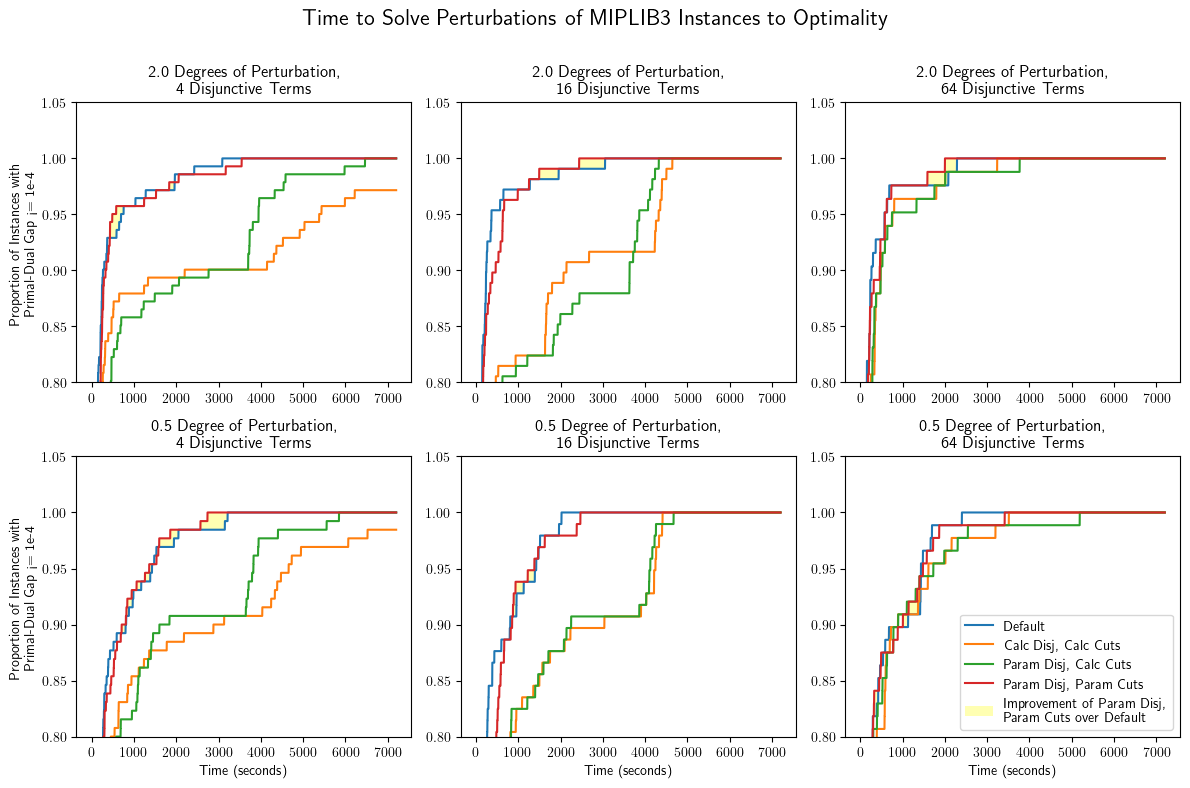

In [69]:
make_plots(time_df, "terminationTime", show_all=True)

# Make node table

In [70]:
# additional filtering for dataframe on nodes processed
fields = ["nodes New", "nodes Old", "nodes Farkas",
          "nodes None", "terminationTimeImprovement"]
node_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    node_df[f] = node_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = node_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "node.csv"), index=False, mode="w")
out

,degree,terms,nodes New,nodes Old,nodes Farkas,nodes None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,23.476108,23.563308,23.222792,24.866338,-0.000167,14,130
1,0.5,16,24.749567,25.511082,25.777309,24.627474,-0.000297,11,97
2,0.5,64,42.844261,38.095477,38.700250,37.881977,-0.000458,9,88
3,2.0,4,17.286546,20.525106,18.331660,20.146333,-0.000209,16,141
4,2.0,16,16.694972,16.600935,16.459565,15.065509,-0.000423,12,108
5,2.0,64,26.410916,27.425313,27.812554,25.124145,-0.000859,9,83


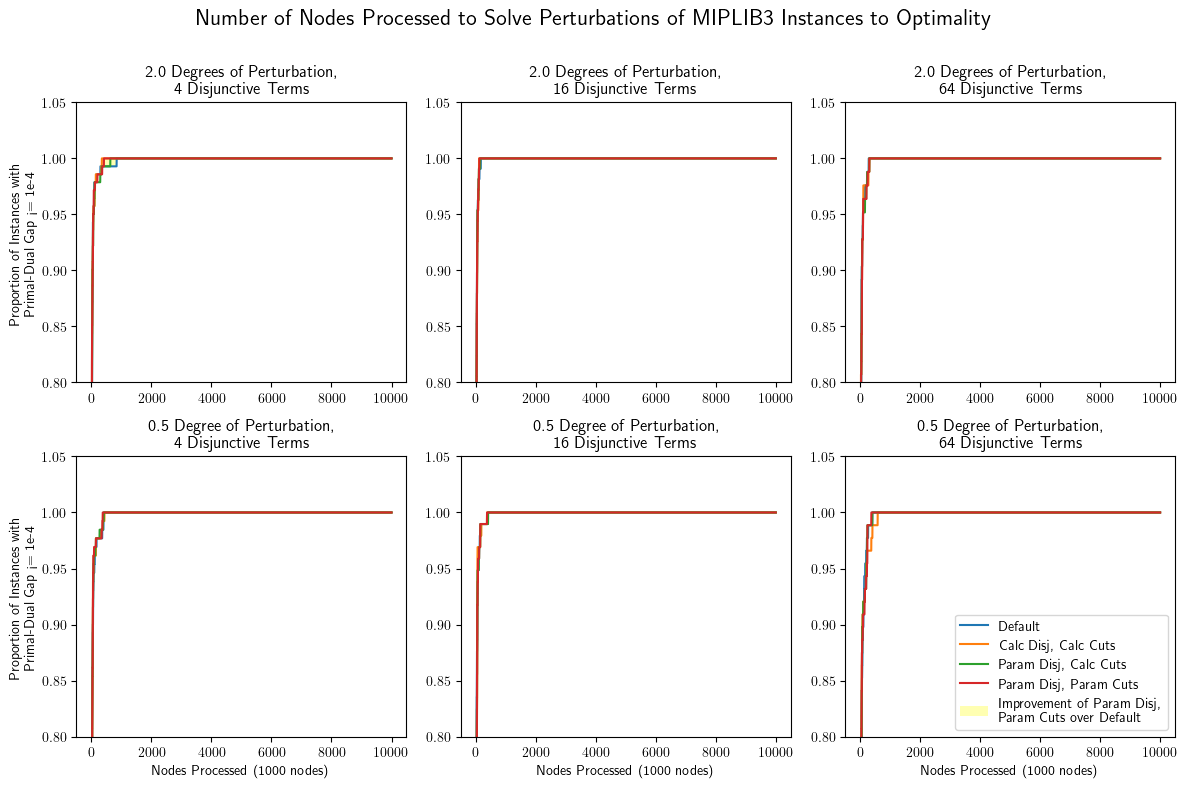

In [71]:
make_plots(node_df, "nodes", show_all=True)

# Make iteration table

In [72]:
# additional filtering for dataframe on nodes processed
fields = ["iterations New", "iterations Old",
          "iterations Farkas", "iterations None",
          "terminationTimeImprovement"]
iteration_df = df.loc[mask, group_cols + id_cols + fields]
for f in fields:
    iteration_df[f] = iteration_df[f] / 1000

# define aggregating operations
aggregations = {f: "mean" for f in fields}
aggregations["instance"] = "nunique"
aggregations["instanceIndex"] = "count"

# get gap closed by degree and term
out = iteration_df.groupby(["degree", "terms"]).agg(aggregations).reset_index()
out.to_csv(os.path.join(out_fldr, "iteration.csv"), index=False, mode="w")
out

,degree,terms,iterations New,iterations Old,iterations Farkas,iterations None,terminationTimeImprovement,instance,instanceIndex
0,0.5,4,1045.541038,1038.435838,1005.953123,1056.097369,-0.000167,14,130
1,0.5,16,1183.988691,1207.504021,1211.624093,1077.458392,-0.000297,11,97
2,0.5,64,1248.782648,1165.050443,1239.751682,1211.492250,-0.000458,9,88
3,2.0,4,760.797411,781.169383,777.988738,783.729482,-0.000209,16,141
4,2.0,16,804.717704,808.709741,794.721194,694.449815,-0.000423,12,108
5,2.0,64,765.302735,766.639867,799.999651,767.960880,-0.000859,9,83


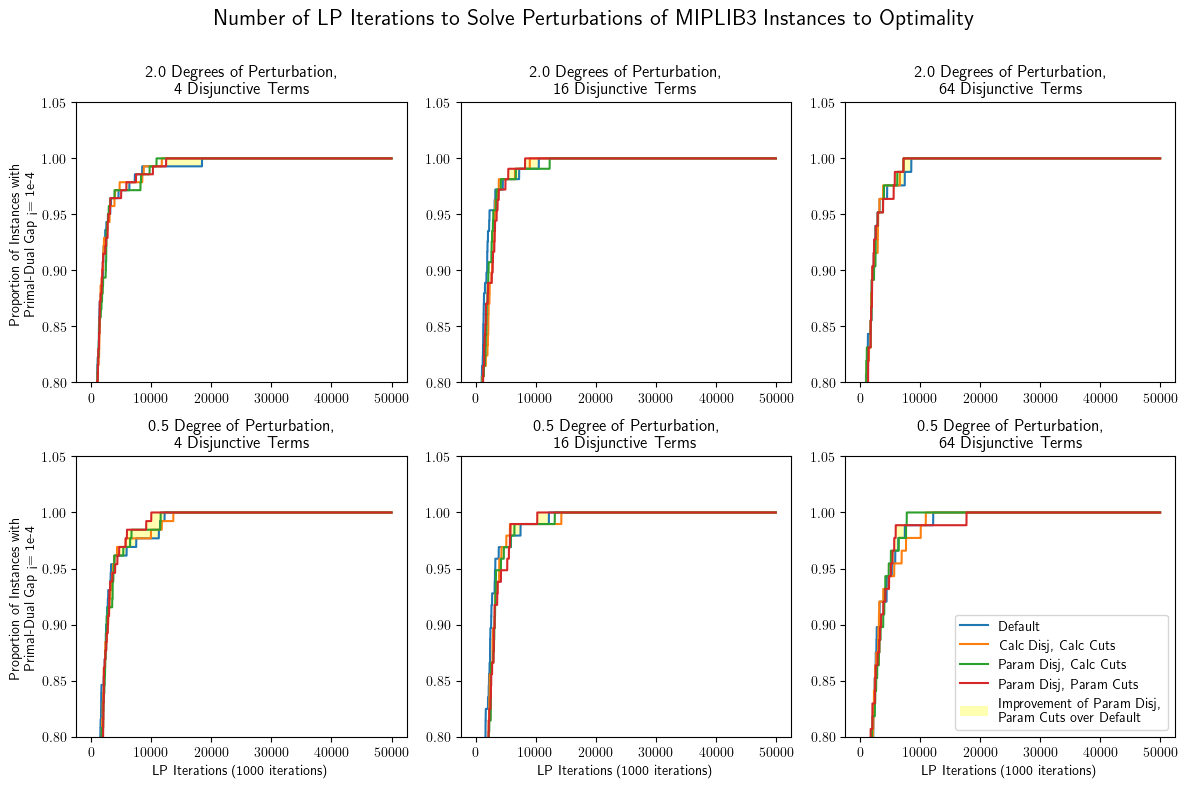

In [73]:
make_plots(iteration_df, "iterations", show_all=True)

## Improvement Consistency

In [74]:
def make_run_time_boxplot(time_df, perturbation=None, threshold=.1):
    plt.rc('text', usetex=True)  # use latex fonts

    # Get unique values of degree and terms
    degrees = time_df['degree'].sort_values(ascending=False).unique()  # sort increasing
    terms = time_df['terms'].sort_values().unique()  # sort decreasing
    
    # Create a grid of subplots
    fig, axes = plt.subplots(len(degrees), len(terms), figsize=(8*len(terms), 4*len(degrees)))
    
    # Iterate through each combination of degree and terms
    for i, degree in enumerate(degrees):
        for j, term in enumerate(terms):
            
            # get the data for this combination
            subset = time_df[(time_df['terms'] == term) &
                             (time_df['degree'] == degree)]
            
            # if we are looking at a specific perturbation, filter for it
            if perturbation is not None:
                subset = subset[subset["perturbation"] == perturbation]
                
            cut_off = subset["terminationTimeImprovement"].quantile(1 - threshold)
            
            # now break it down by instance
            unique_instances = subset['instance'].sort_values().unique()
            instance_data = [subset[subset['instance'] == instance]['terminationTimeImprovement'].tolist()
                             for instance in unique_instances]
            
            # make all the boxplots for this plot
            axes[i, j].boxplot(instance_data, labels=unique_instances)
            axes[i, j].axhline(cut_off, color='black', linestyle='--', linewidth=1, alpha=.5, label=f"Top {int(threshold * 100)} Percent of Instances")
            axes[i, j].set_ylim(-3, 1)
            axes[i, j].set_xticklabels(axes[i, j].get_xticklabels(), rotation=90)
            axes[i, j].set_title(f"{degree} Degree{'s' if degree >= 2 else ''} "
                                 f"of Perturbation,\n{term} Disjunctive Terms")
            if j == 0:
                axes[i, j].set_ylabel('Relative Time Improvement\n'
                                      '(Param Disj, Param Cuts vs Default)')
            if i == len(degrees) - 1:
                axes[i, j].set_xlabel('Instance')
    
    fig.suptitle(f"Distributions of Relative Time Improvement for Param Disj, "
                 f"Param Cuts compared to Default"
                 f"{' - perturbing only ' + perturbation if perturbation else ''}\n"
                 f"(positive values imply Param Disj, Param Cuts'"
                 f" run time faster than Default's)", fontsize=16)
    
    plt.tight_layout()
    plt.savefig(os.path.join(out_fldr, f"time_improvement_distribution"
                                       f"{'_' + perturbation if perturbation else ''}.png"),
                dpi=1200)
    plt.legend()
    plt.show()

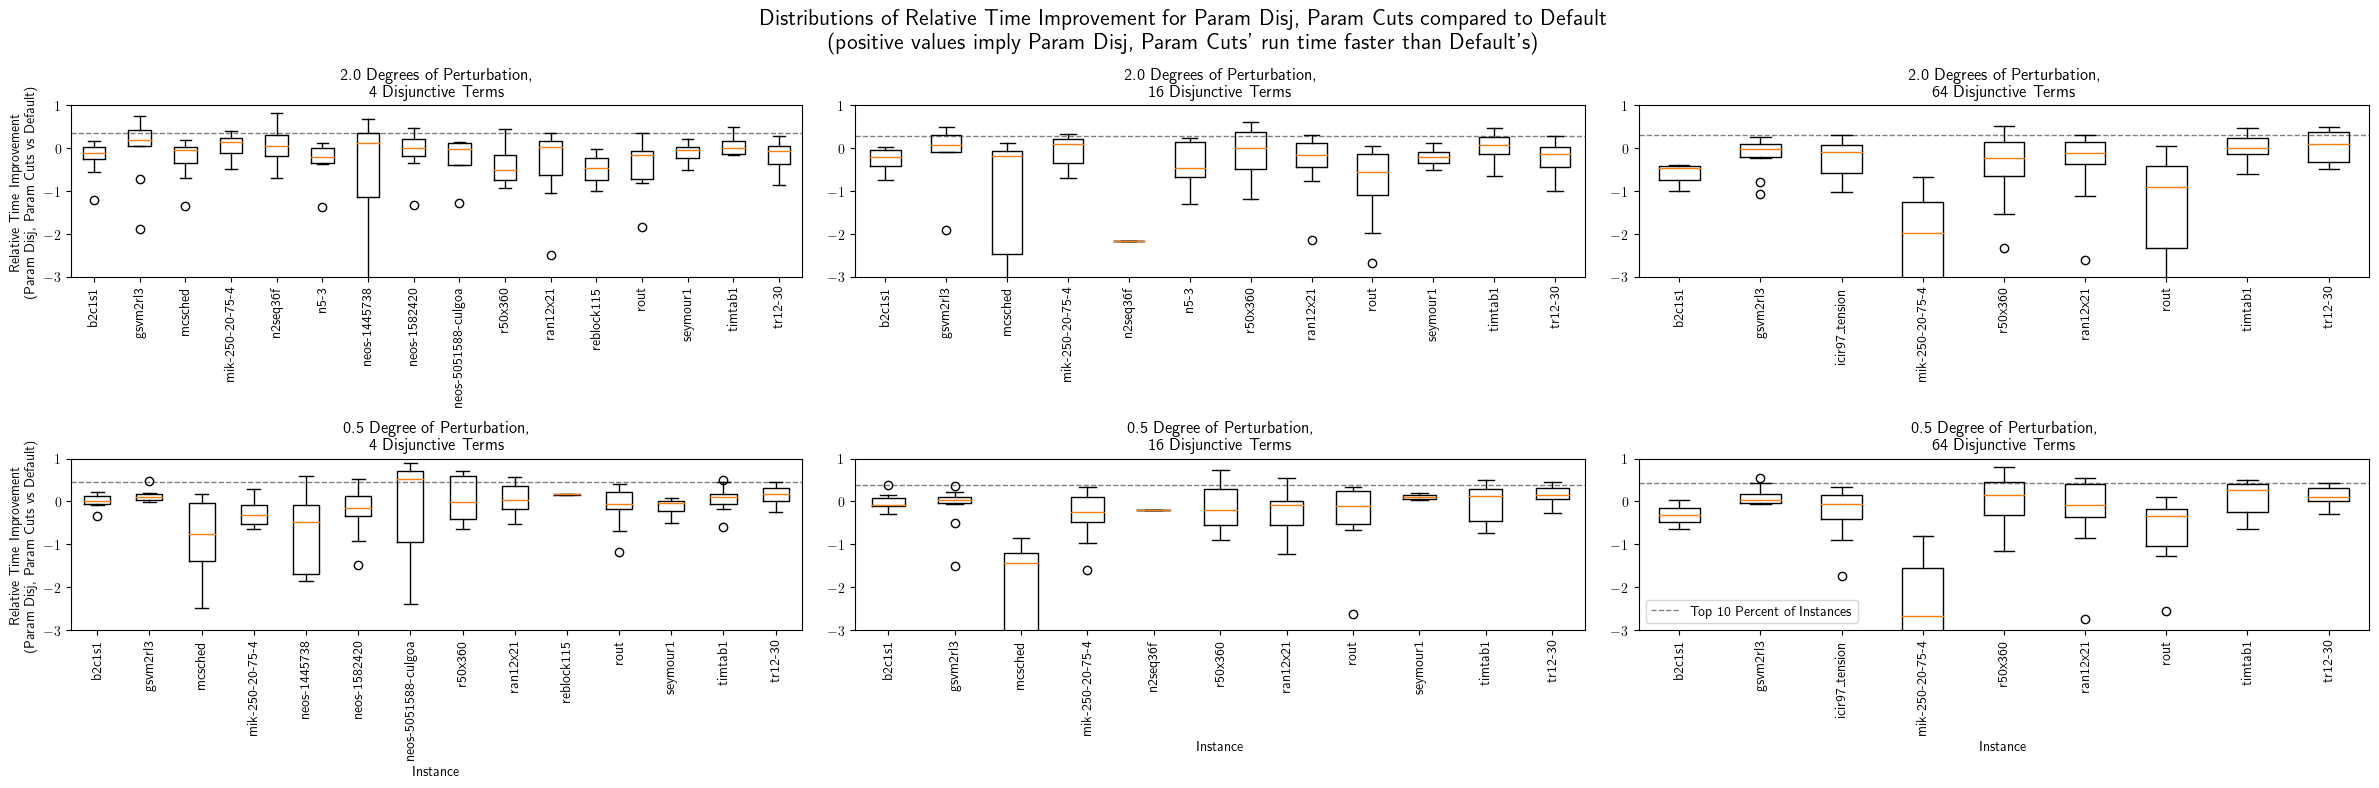

In [75]:
make_run_time_boxplot(time_df)

In [76]:
# get a table of all unperturbed instances that solved to optimality
df_zero = df_map["None"].loc[(df_map["None"]["instanceIndex"] == 0) & (optimality_gap(df_map["None"]) <= 1e-4)]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


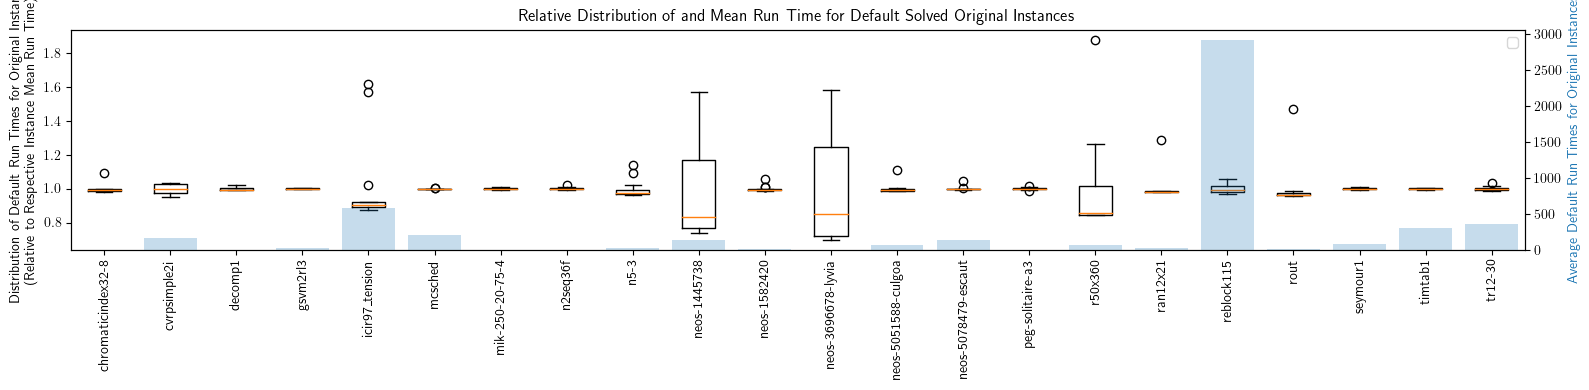

In [77]:
# configure plot
plt.rc('text', usetex=True)
fig, ax1 = plt.subplots(figsize=(16, 4))

# now break it down by instance
mean_run = df_zero.groupby("instance")["terminationTime"].mean().to_dict()
data = {instance: df_zero[df_zero['instance'] == instance]['terminationTime'].values / time
         for instance, time in mean_run.items()}

# make all the boxplots for this plot
ax1.boxplot(data.values(), labels=data.keys())
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel('Distribution of Default Run Times for Original Instances\n'
               '(Relative to Respective Instance Mean Run Time)')
ax1.set_title("Relative Distribution of and Mean Run Time for Default Solved Original Instances")

# make the barchart for this plot
ax2 = ax1.twinx()
color = 'tab:blue'
plt.bar(np.arange(1, len(mean_run) + 1), mean_run.values(), alpha=.25, color=color)
ax2.set_ylabel('Average Default Run Times for Original Instances', color=color)

plt.tight_layout()
plt.savefig(os.path.join(out_fldr, "original_distribution.png"), dpi=1200)
plt.legend()
plt.show()

## Check Root Optimality Gap Relationships

In [78]:
gap_df = df.loc[mask]  # & (df["terms"] == 64) & (df["degree"] == .5)]

In [79]:
gap_df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

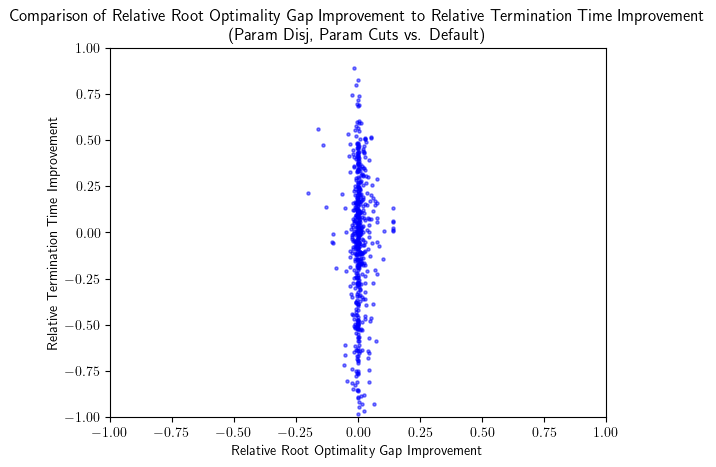

In [80]:
plt.scatter(gap_df["Root Optimality Gap Improvement"], gap_df["terminationTimeImprovement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.title("Comparison of Relative Root Optimality Gap Improvement to Relative Termination Time Improvement\n"
          "(Param Disj, Param Cuts vs. Default)")
plt.xlabel("Relative Root Optimality Gap Improvement")
plt.ylabel("Relative Termination Time Improvement")
plt.savefig(os.path.join(out_fldr, "gap_vs_time.png"), dpi=1200)
plt.show()

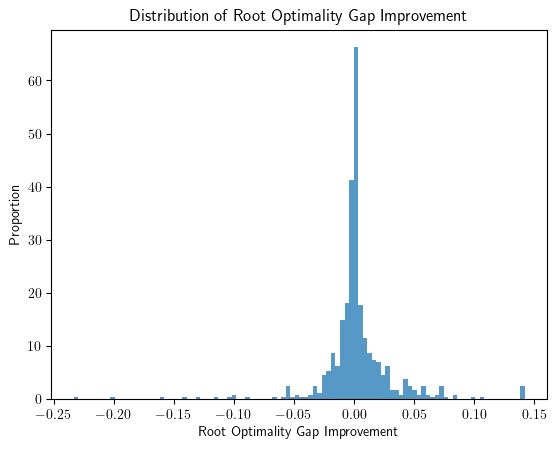

In [81]:
# Create a histogram with 100 bins
plt.hist(gap_df.loc[(-.5 < gap_df["Root Optimality Gap Improvement"]) & (gap_df["Root Optimality Gap Improvement"] < .5),
                    "Root Optimality Gap Improvement"], bins=100, density=True, alpha=0.75)

# Add labels and a title
plt.xlabel('Root Optimality Gap Improvement')
plt.ylabel('Proportion')
plt.title('Distribution of Root Optimality Gap Improvement')

# Display the plot
plt.show()

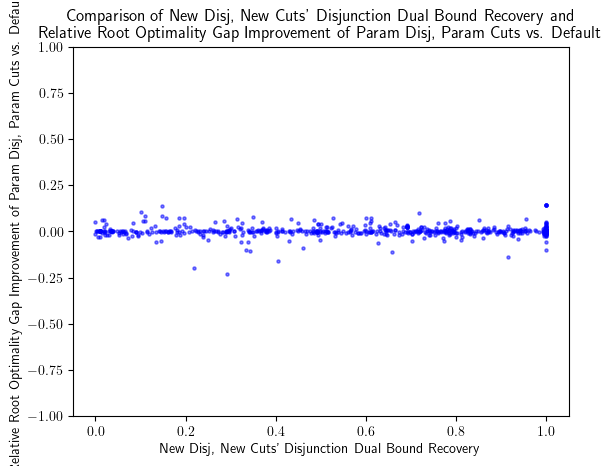

In [82]:
# is there a relationship between how much of dual bound we recover and root optimality gap improvement
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["Root Optimality Gap Improvement"],
            marker='o', color='blue', s=5, alpha=0.5)
plt.ylim(-1, 1)
plt.title("Comparison of New Disj, New Cuts' Disjunction Dual Bound Recovery and\n"
          "Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Relative Root Optimality Gap Improvement of Param Disj, Param Cuts vs. Default")
plt.show()

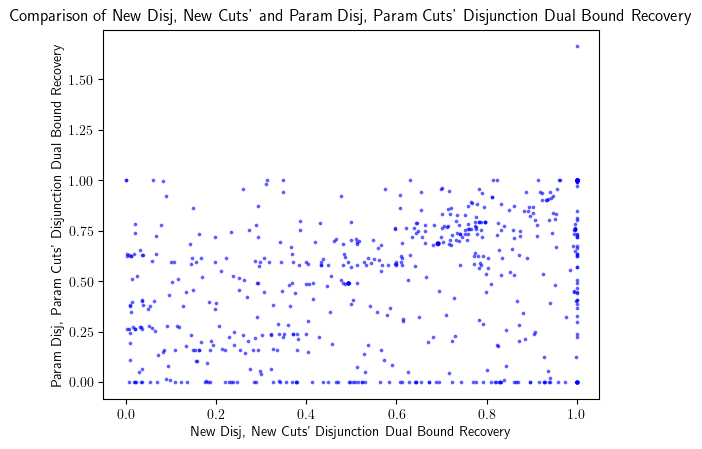

In [83]:
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["VPCs (New)"] / gap_df["Disjunction (New)"],
            gap_df["VPCs (Farkas)"] / gap_df["Disjunction (Old)"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.title("Comparison of New Disj, New Cuts' and Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.xlabel("New Disj, New Cuts' Disjunction Dual Bound Recovery")
plt.ylabel("Param Disj, Param Cuts' Disjunction Dual Bound Recovery")
plt.show()  # todo: what happens when Param Disj, Param Cuts recovers the same amount of dual bound?

In [84]:
df.columns

Index(['instanceIndex', 'vpcGenerator None', 'terms', 'lpBound None',
       'disjunctiveDualBound None', 'lpBoundPostVpc None',
       'rootDualBound None', 'dualBound None', 'primalBound None',
       'vpcGenerationTime None',
       ...
       'rootDualBoundTimeSansVpc New', 'rootDualBoundTimeSansVpc Old',
       'rootDualBoundTimeSansVpc Farkas', 'postRootTime None',
       'postRootTime New', 'postRootTime Old', 'postRootTime Farkas',
       'terminationTimeImprovement', 'nodeImprovement',
       'iterationImprovement'],
      dtype='object', length=106)

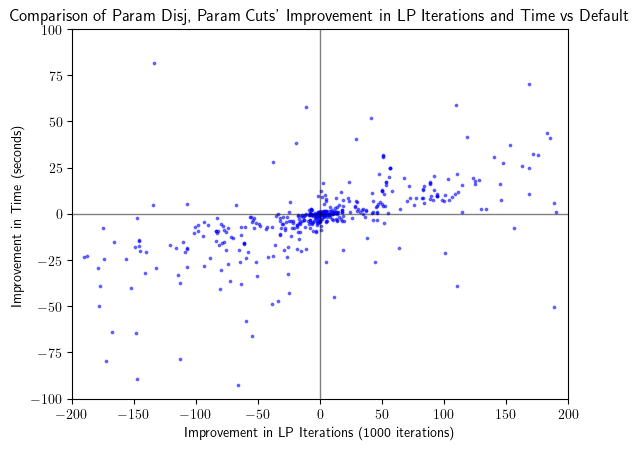

In [85]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations None"]/1000 - gap_df["iterations Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-200, 200)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in LP Iterations and Time vs Default")
plt.xlabel("Improvement in LP Iterations (1000 iterations)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "lp_iters_vs_time.png"), dpi=1200)
plt.show()

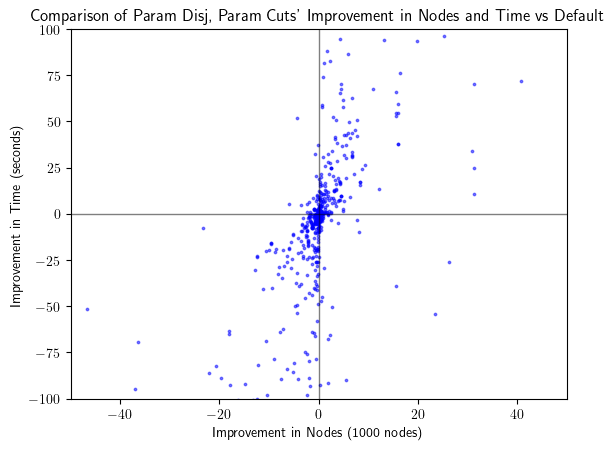

In [86]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["nodes None"]/1000 - gap_df["nodes Farkas"]/1000,
            gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-50, 50)
plt.ylim(-100, 100)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and Time vs Default")
plt.xlabel("Improvement in Nodes (1000 nodes)")
plt.ylabel("Improvement in Time (seconds)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_time.png"), dpi=1200)
plt.show()

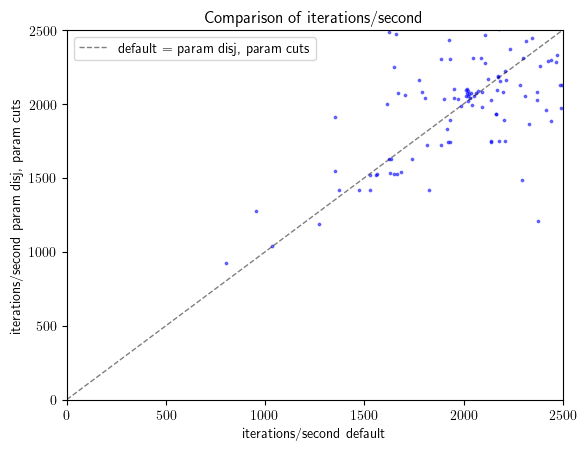

In [87]:
# plot iteration improvement over termination time improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
plt.scatter(gap_df["iterations Farkas"]/gap_df["terminationTimeSansVpc Farkas"],
            gap_df["iterations None"]/gap_df["terminationTimeSansVpc None"],
            marker='o', color='blue', s=3, alpha=0.5)
# plot the line y = x
x = np.linspace(0, 3000, 3000)
plt.plot(x, x, linestyle='--', color='black', linewidth=1, alpha=.5,
         label="default = param disj, param cuts")
plt.xlim(0, 2500)
plt.ylim(0, 2500)
plt.title("Comparison of iterations/second")
plt.xlabel("iterations/second default")
plt.ylabel("iterations/second param disj, param cuts")
plt.legend()
plt.savefig(os.path.join(out_fldr, "lp_iters_per_second.png"), dpi=1200)
plt.show()

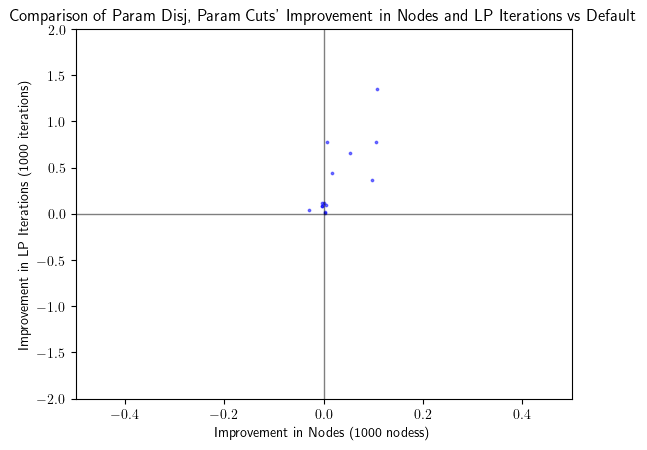

In [88]:
# plot node improvement over iteration improvement
# is there a relationship between how much of dual bound we recover with New vs Farkas VPCs
tdf = gap_df.loc[(gap_df["iterationImprovement"] > 0) & (gap_df["terminationTimeImprovement"] < 0)]
plt.scatter(tdf["nodes None"]/1000 - tdf["nodes Farkas"]/1000,
            tdf["iterations None"]/1000 - tdf["iterations Farkas"]/1000,
            marker='o', color='blue', s=3, alpha=0.5)
plt.xlim(-.5, .5)
plt.ylim(-2, 2)
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.axhline(0, color='black', linestyle='-', linewidth=1, alpha=.5)
plt.title("Comparison of Param Disj, Param Cuts' Improvement in Nodes and LP Iterations vs Default")
plt.xlabel("Improvement in Nodes (1000 nodess)")
plt.ylabel("Improvement in LP Iterations (1000 iterations)")
plt.savefig(os.path.join(out_fldr, "nodes_vs_lp_iters_werid.png"), dpi=1200)
plt.show()

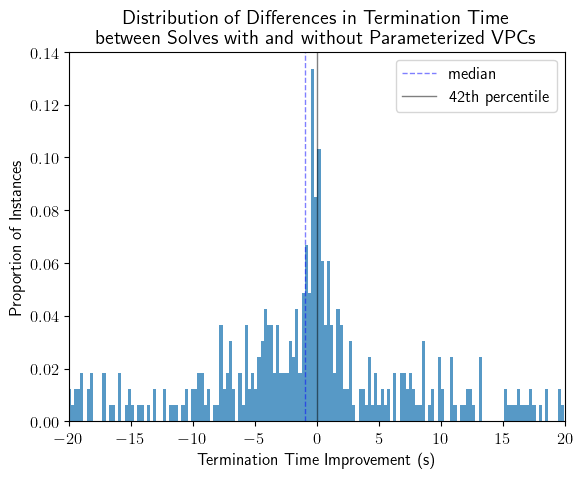

In [89]:
plt.rc('text', usetex=True)
plt.rcParams['font.size'] = 12

# Create a histogram with 600 bins
plt.hist(gap_df["terminationTime None"] - gap_df["terminationTime Farkas"],
         bins=14400, density=True, alpha=0.75)
plt.xlim(-20, 20)

cut_off = (gap_df["terminationTime None"] - gap_df["terminationTime Farkas"]).quantile(.5)
zeroth_percentile = int(100 * round((gap_df["terminationTime None"] >= gap_df["terminationTime Farkas"]).sum() / len(gap_df), 2))
plt.axvline(cut_off, color='blue', linestyle='--', linewidth=1, alpha=.5, label=f"median")
plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=.5, label=f"{zeroth_percentile}th percentile")

# Add labels and a title
plt.xlabel('Termination Time Improvement (s)')
plt.ylabel('Proportion of Instances')
plt.title('Distribution of Differences in Termination Time\nbetween Solves with and without Parameterized VPCs')

# Display the plot
plt.legend()
plt.savefig(os.path.join(out_fldr, "time_improvement_distribution.png"), dpi=1200)
plt.show()

In [90]:
gap_df

,instanceIndex,vpcGenerator None,terms,lpBound None,disjunctiveDualBound None,lpBoundPostVpc None,rootDualBound None,dualBound None,primalBound None,vpcGenerationTime None,...,rootDualBoundTimeSansVpc New,rootDualBoundTimeSansVpc Old,rootDualBoundTimeSansVpc Farkas,postRootTime None,postRootTime New,postRootTime Old,postRootTime Farkas,terminationTimeImprovement,nodeImprovement,iterationImprovement
1,1,None,64,-298210.696538,-298210.696538,-298210.696538,-283858.441537,-280905.707827,-280877.678000,0.000003,...,8.258174,5.786397,5.893158,116.442745,135.264054,132.632443,143.847452,-0.469255,-0.119711,-0.296780
2,3,None,64,-507082.174896,-507082.174896,-507082.174896,-489988.125727,-487691.846907,-487672.270067,0.000002,...,4.466357,4.380241,4.176310,60.392489,72.921364,68.141931,92.593743,-1.013097,-0.688507,-0.597161
3,10,None,64,-380504.487198,-380504.487198,-380504.487198,-364341.870930,-361775.408255,-361740.417995,0.000003,...,6.002802,8.314730,6.611926,117.107940,98.732430,122.853092,131.801748,-0.387072,-0.117308,-0.203105
5,1,None,16,2988.707109,2988.707109,2988.707109,3310.817095,3439.692655,3440.000000,0.000004,...,0.336259,0.402646,0.341431,9.518164,7.702448,8.507121,7.812284,0.162692,0.213722,0.115142
6,2,None,16,3065.343777,3065.343777,3065.343777,3400.621794,3529.000000,3528.999985,0.000003,...,0.340057,0.336636,0.362782,8.467207,10.228867,12.908962,15.143270,-0.768474,-0.520930,-0.633755
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
890,1,None,16,0.010856,0.010856,0.010856,0.039218,0.321228,0.321228,0.000002,...,0.201315,0.233131,0.160378,64.830546,211.213321,161.204482,188.518535,-1.904086,-2.586132,-2.049929
891,2,None,16,0.010572,0.010572,0.010572,0.025866,0.178185,0.178198,0.000003,...,0.175082,0.380797,0.218063,11.935452,15.633028,5.788457,12.845771,-0.091211,-0.013456,0.129985
892,3,None,16,0.009762,0.009762,0.009762,0.036309,0.252931,0.252948,0.000002,...,0.231645,0.278746,0.292792,230.552268,326.717747,220.328131,119.787580,0.478970,0.477367,0.486380
893,4,None,16,0.011922,0.011922,0.011922,0.044839,0.329957,0.329987,0.000002,...,0.201841,0.304242,0.307389,570.105235,369.150618,349.185835,384.148373,0.325559,0.292359,0.288242


## See Where My Work Went off the Rails

In [91]:
# create a table to compare unperturbed instances with aleks' results for them
groups = ["instance", "terms"]
fields = ["lpBound New", "disjunctiveDualBound New", "lpBoundPostVpc New", "rootDualBound None",
          "rootDualBound New", "primalBound None", "terminationTime None", "Root Cuts (New)", "Root Cuts (None)"]
comp = df.loc[df["instanceIndex"] == 0, groups + fields].groupby(groups).mean().reset_index()
comp.to_csv(os.path.join(out_fldr, "unperturbed_bound_table.csv"), index=False, mode="w")
comp

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,b2c1s1,4,6.108699e+03,6.116949e+03,6.114949e+03,2.012390e+04,1.997850e+04,2.568791e+04,3600.003682,0.708394,0.715820
1,b2c1s1,16,6.108699e+03,6.139032e+03,6.117449e+03,2.012390e+04,2.028419e+04,2.568791e+04,3600.005121,0.724007,0.715820
2,b2c1s1,64,6.108699e+03,6.501749e+03,6.116949e+03,2.012390e+04,1.987853e+04,2.568791e+04,3600.001764,0.703288,0.715820
3,decomp1,16,-1.200000e+02,-1.200000e+02,-1.200000e+02,-1.200000e+02,-1.200000e+02,-1.200000e+02,1.023443,NaN,NaN
4,decomp1,64,-1.200000e+02,-1.200000e+02,-1.200000e+02,-1.200000e+02,-1.200000e+02,-1.200000e+02,1.015486,NaN,NaN
5,gsvm2rl3,4,1.200000e-02,3.096800e-02,3.096800e-02,9.048700e-02,1.366320e-01,3.365275e-01,34.460538,0.384041,0.241850
6,gsvm2rl3,16,1.200000e-02,5.071000e-02,1.823400e-02,9.048700e-02,8.955800e-02,3.365275e-01,34.438550,0.238987,0.241850
7,gsvm2rl3,64,1.200000e-02,7.282800e-02,4.837100e-02,9.048700e-02,1.146600e-01,3.365275e-01,34.512297,0.316337,0.241850
8,icir97_tension,64,6.302000e+03,6.302000e+03,6.302000e+03,6.356108e+03,6.356594e+03,6.375000e+03,615.184039,0.747869,0.741208
9,mcsched,4,1.937748e+05,1.937978e+05,1.937962e+05,1.938304e+05,1.938229e+05,2.119130e+05,207.431698,0.002653,0.003070


In [92]:
# create a table with aleks's results for the unperturbed instances 
adf = pd.read_csv("aleks_results.csv")
adf = adf[["INSTANCE", "disj_terms", "LP OBJ", "BEST DISJ OBJ", "VPC OBJ", "AVG REF LAST_CUT_PASS", "AVG REF+V LAST_CUT_PASS", "ip_obj", "BEST REF TIME"]]
adf["rcnew"] = abs(adf["AVG REF+V LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"]) 
adf["rcnone"] = abs(adf["AVG REF LAST_CUT_PASS"] - adf["LP OBJ"]) / abs(adf["ip_obj"] - adf["LP OBJ"])
adf.columns = groups + fields
adf['instance'] = adf['instance'].str.replace('_presolved', '')
adf['instance'] = adf['instance'].str.replace('mas0', 'mas')
adf = adf.loc[(0 <= adf["Root Cuts (New)"]) & (adf["Root Cuts (New)"] <= 1)]

In [93]:
# join comp and adf on instance and terms to get a comparison of the two and see what's missing
keep_cols = groups + ["Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
both = comp[keep_cols].merge(adf[keep_cols], on=groups, suffixes=(" sean", " aleks"), how="outer")
both

,instance,terms,Root Cuts (New) sean,Root Cuts (None) sean,terminationTime None sean,Root Cuts (New) aleks,Root Cuts (None) aleks,terminationTime None aleks
0,b2c1s1,4.0,0.708394,0.71582,3600.003682,0.722745,0.720376,3600.000
1,b2c1s1,16.0,0.724007,0.71582,3600.005121,0.721983,0.720376,3600.000
2,b2c1s1,64.0,0.703288,0.71582,3600.001764,0.719178,0.720376,3600.000
3,decomp1,16.0,NaN,NaN,1.023443,NaN,NaN,NaN
4,decomp1,64.0,NaN,NaN,1.015486,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2057,umts,64.0,NaN,NaN,NaN,0.049433,0.047454,49.839
2058,usAbbrv-8-25_70,64.0,NaN,NaN,NaN,0.000000,0.000000,3600.000
2059,vpm1,64.0,NaN,NaN,NaN,0.721295,0.681575,0.004
2060,vpm2,64.0,NaN,NaN,NaN,0.719205,0.718862,0.098


In [94]:
# make a dataframe that compares the experiments we both ran
diff = both.loc[~pd.isna(both["Root Cuts (New) sean"]) & ~pd.isna(both["Root Cuts (New) aleks"])]
diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]

# get some summary stats - looks like we are pretty close
# I expect the difference is that I'm not adding GMICs and I'm using different sized disjunctions 
diff[diff.columns[2:]].mean()

/var/folders/pb/p1sshdnx5sv12zwsxff8nrg40000gn/T/ipykernel_6905/3402183073.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff["improvement aleks"] = (diff["Root Cuts (New) aleks"] - diff["Root Cuts (None) aleks"]) / diff["Root Cuts (None) aleks"]


Root Cuts (New) sean            0.551160
Root Cuts (None) sean           0.538403
terminationTime None sean     560.092916
Root Cuts (New) aleks           0.546302
Root Cuts (None) aleks          0.537274
terminationTime None aleks    406.597211
improvement aleks               0.139514
dtype: float64

In [95]:
# let's examine the instances for which I don't have data
mdf = both.loc[(both["Root Cuts (None) sean"].isna()) & (both["terms"].isin([4, 16, 64])),
               ["instance", "terms", "Root Cuts (New) aleks", "Root Cuts (None) aleks", "terminationTime None aleks"]]
mdf.columns = ["instance", "terms", "Root Cuts (New)", "Root Cuts (None)", "terminationTime None"]
mdf["improvement"] = (mdf["Root Cuts (New)"] - mdf["Root Cuts (None)"]) / mdf["Root Cuts (None)"]
mdf

,instance,terms,Root Cuts (New),Root Cuts (None),terminationTime None,improvement
3,decomp1,16.0,NaN,NaN,NaN,NaN
4,decomp1,64.0,NaN,NaN,NaN,NaN
391,22433,4.0,0.675821,0.667379,0.093,0.012649
392,23588,4.0,0.318880,0.243813,0.420,0.307885
393,10teams,4.0,1.000000,1.000000,0.301,0.000000
...,...,...,...,...,...,...
2057,umts,64.0,0.049433,0.047454,49.839,0.041720
2058,usAbbrv-8-25_70,64.0,0.000000,0.000000,3600.000,NaN
2059,vpm1,64.0,0.721295,0.681575,0.004,0.058276
2060,vpm2,64.0,0.719205,0.718862,0.098,0.000477


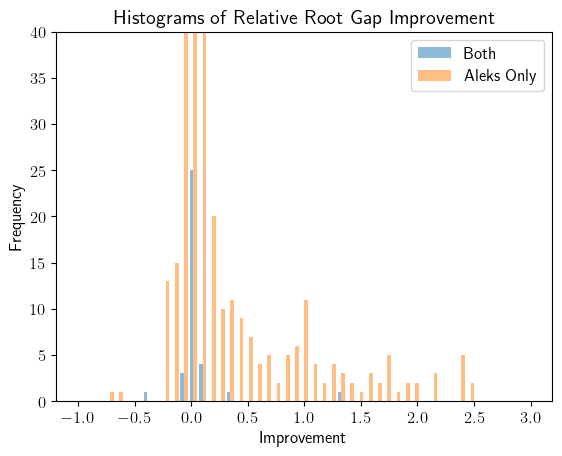

In [96]:
# Plot histograms
plt.hist([diff["improvement aleks"], mdf["improvement"]], bins=np.linspace(-1, 3, 50), alpha=0.5, label=['Both', 'Aleks Only'])

plt.ylim(0, 40)

# Add labels and title
plt.xlabel('Improvement')
plt.ylabel('Frequency')
plt.title('Histograms of Relative Root Gap Improvement')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [97]:
# set the index of mdf to the combination of instance and terms
mdf = mdf.set_index(["instance", "terms"])
mdf

Root Cuts (New)  Root Cuts (None)  \
instance        terms                                      
decomp1         16.0               NaN               NaN   
                64.0               NaN               NaN   
22433           4.0           0.675821          0.667379   
23588           4.0           0.318880          0.243813   
10teams         4.0           1.000000          1.000000   
...                                ...               ...   
umts            64.0          0.049433          0.047454   
usAbbrv-8-25_70 64.0          0.000000          0.000000   
vpm1            64.0          0.721295          0.681575   
vpm2            64.0          0.719205          0.718862   
zib54-UUE       64.0          0.681297          0.687208   

                       terminationTime None  improvement  
instance        terms                                     
decomp1         16.0                    NaN          NaN  
                64.0                    NaN          NaN  
22433           4.0                   0.093     0.012649  
23588           4.0                   0.420     0.307885  
10teams         4.0                   0.301     0.000000  
...                                     ...          ...  
umts            64.0                 49.839     0.041720  
usAbbrv-8-25_70 64.0               3600.000          NaN  
vpm1            64.0                  0.004     0.058276  
vpm2            64.0                  0.098     0.000477  
zib54-UUE       64.0                103.298    -0.008602  

[990 rows x 4 columns]

In [102]:
# classify missing experiment data by excluded instance (either aleks' mislabeled or I just missed), max run time, unperturbable, or run time error
mdf["reason"] = "unknown"

# read in list of dropped instances from aleks' data set
# i think the issue is some aleks tested despite saying he wasn't and others were more than 5k x 5k rows but preprocess to less
dropped = pd.read_csv("dropped.csv", index_col="instance")

for (instance, terms) in mdf.index:
    cur_inst_test_set_fldr = os.path.join(test_set_fldr, instance)
    if instance + ".mps" not in os.listdir(instance_fldr):
        if instance in dropped.index:
            mdf.loc[(instance, terms), "reason"] = "dropped"  # excluded by vpc
        else:
            mdf.loc[(instance, terms), "reason"] = "missed"  # not run yet
    elif mdf.loc[(instance, terms), "terminationTime None"] > 3599:
        mdf.loc[(instance, terms), "reason"] = "max run time"  # hit the max run time
    elif not os.path.exists(cur_inst_test_set_fldr) or not os.listdir(cur_inst_test_set_fldr):
        mdf.loc[(instance, terms), "reason"] = "unperturbable"  # weren't able to perturb
    else:
        mdf.loc[(instance, terms), "reason"] = "runtime error"  # crashed or ran within 1 hour but no results data

In [103]:
# summary stats on where our improving runs are hiding
stats = mdf.groupby("reason").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
stats.rename(columns={"improvement": "count"}, inplace=True)
stats["weighted improvement"] = (stats["Root Cuts (New)"] - stats["Root Cuts (None)"]) * stats["count"]
stats["weighted improvement"] = (stats["weighted improvement"] / stats["weighted improvement"].sum()).round(4)
stats.sort_values("weighted improvement", ascending=False)

,reason,Root Cuts (New),Root Cuts (None),count,weighted improvement
2,missed,0.498358,0.450770,300,0.5378
3,runtime error,0.376295,0.328003,135,0.2456
0,dropped,0.738627,0.621918,48,0.2110
1,max run time,0.269495,0.267591,58,0.0042
4,unperturbable,0.523079,0.521500,23,0.0014


In [104]:
# track down the experiments we excluded because we missed creating them
# stein9 is an outlier pushing things up
missing = mdf[mdf["reason"] == "missed"]
missing

,,Root Cuts (New),Root Cuts (None),terminationTime None,improvement,reason
instance,terms,,,,,
bc,4.0,0.302212,0.302552,35.878,-0.001122,missed
bc1,4.0,0.427863,0.448678,6.347,-0.046393,missed
bell3a,4.0,0.478648,0.478648,0.214,0.000000,missed
bell3b,4.0,0.901596,0.491740,0.121,0.833481,missed
bell5,4.0,0.284498,0.294200,0.038,-0.032977,missed
...,...,...,...,...,...,...
stein45_nocard,64.0,0.590909,0.263384,3.653,1.243528,missed
tanglegram2,64.0,1.000000,0.980850,0.047,0.019524,missed
timtab2,64.0,0.480566,0.476907,3600.000,0.007673,missed


In [105]:
# let's look at what aleks "missed"
aleks_missing = both.loc[pd.isna(both["Root Cuts (New) aleks"])].drop_duplicates("instance").sort_values("instance")
aleks_missing["row"], aleks_missing["col"], aleks_missing["source"] = 0, 0, "unknown"
aleks_missing.set_index("instance", inplace=True)

# get problem size
for instance in aleks_missing.index:
    aleks_missing.loc[instance, "row"] = rows.get(instance, 0)
    aleks_missing.loc[instance, "col"] = cols.get(instance, 0)
    
# get source of instance
for instance in aleks_missing.index:
    for fldr in os.listdir("../../"):
        if not os.path.isdir(f"../../{fldr}"):
            continue
        if instance + ".mps" in os.listdir(f"../../{fldr}") or instance + ".mps.gz" in os.listdir(f"../../{fldr}"):
            aleks_missing.loc[instance, "source"] = fldr

# trim down to what we want - looks like mas misnamed but otherwise we are good
aleks_missing = aleks_missing[["row", "col", "source"]]
aleks_missing

,row,col,source
instance,,,
app2-2,335,1226,miplib2017
arki001,1048,1388,miplib3
beavma,372,390,miplib2017
ci-s4,26159,745,miplib2017
decomp1,8357,10735,miplib2017
f2gap401600,40,1600,miplib2017
gen-ip054,27,30,miplib2017
haprp,1048,1828,miplib2017
irp,39,20315,miplib2017


In [106]:
# now lets track down which error modes are sinking us most
run_error = mdf[mdf["reason"] == "runtime error"]

# collect the ways each instance/term combination fails
err_map = []

# iterate over instances and terms of aleks' tests we're missing because of run errors
for instance, terms in run_error.index:
    terms = int(terms)
    found_err = False
    
    # iterate over our error modes to find matches
    for mode, failed_experiments in err.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                
                # if we find a match, see if we can get a more specific error mode
                sub_mode = mode
                if sub_mode == "no vpcs were made from a new disjunction":
                    sub_mode = [vpc_err_mode for vpc_err_mode, vpc_err_exps in vpc_err.items()
                            if failed_experiment in vpc_err_exps].pop()
                
                # append the mode
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": sub_mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # do the same thing as the above for all other termination modes
    misc = {"other": other, "warning": warning, "empty": empty}
    for mode, failed_experiments in misc.items():
        for failed_experiment in failed_experiments:
            if f"{instance}_" in failed_experiment and f"_{terms}_" in failed_experiment:
                err_map.append({
                    "instance": instance,
                    "terms": float(terms),
                    "mode": mode,
                    "experiment": failed_experiment,
                    "experiment group": "_".join(failed_experiment.split("_")[:-1]),
                    "cut type": failed_experiment.split("_")[-1]
                })
                found_err = True
                
    # double check to make sure we didn't miss any of aleks' runs for another reason
    if not found_err:
        print("no code for", instance, terms)
        
# add the error mode to the dataframe
run_error = pd.merge(run_error, pd.DataFrame(err_map).set_index(["instance", "terms"]), left_index=True, right_index=True)

# now drop the runs that showed up as failures only because their siblings failed
empty = run_error[(run_error["mode"] == "empty")]
non_empty = run_error[run_error["mode"] != "empty"]
collateral = pd.merge(empty, non_empty[["experiment group", "experiment"]],
                      on="experiment group", how="left", suffixes=("", " collateral"))
false_negs = collateral.loc[~collateral["experiment collateral"].isna(), "experiment"].unique()
run_error = run_error[~run_error["experiment"].isin(false_negs)]

run_error

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
10teams  16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
10teams  16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
...                     ...            ...   
umts     64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   

                                                             mode  \
instance terms                                                      
10teams  16.0                                  segmentation fault   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                   experiment        experiment group cut type  
instance terms                                                                  
10teams  16.0         10teams_bound_1_16_None      10teams_bound_1_16     None  
         16.0      10teams_objective_1_16_New  10teams_objective_1_16      New  
         16.0      10teams_objective_1_16_Old  10teams_objective_1_16      Old  
         16.0   10teams_objective_1_16_Farkas  10teams_objective_1_16   Farkas  
         16.0         10teams_matrix_1_16_New     10teams_matrix_1_16      New  
...                                       ...                     ...      ...  
umts     64.0        umts_objective_-1_64_Old    umts_objective_-1_64      Old  
         64.0     umts_objective_-1_64_Farkas    umts_objective_-1_64   Farkas  
         64.0             umts_bound_1_64_New         umts_bound_1_64      New  
         64.0             umts_bound_1_64_Old         umts_bound_1_64      Old  
         64.0          umts_bound_1_64_Farkas         umts_bound_1_64   Farkas  

[2695 rows x 9 columns]

In [107]:
# summary stats on where improvements are by failure mode
run_error_stats = run_error.groupby("mode").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'improvement': 'count'}).reset_index()
run_error_stats.rename(columns={"improvement": "count"}, inplace=True)
run_error_stats["weighted improvement"] = (run_error_stats["Root Cuts (New)"] - run_error_stats["Root Cuts (None)"]) * run_error_stats["count"]
run_error_stats["weighted improvement"] = (run_error_stats["weighted improvement"] / run_error_stats["weighted improvement"].sum()).round(4)
run_error_stats.sort_values("weighted improvement", ascending=False)

,mode,Root Cuts (New),Root Cuts (None),count,weighted improvement
2,CglVPC: Finishing with exit reason: OPTIMAL_SO...,0.614558,0.376642,285,0.6488
4,CglVPC: Finishing with exit reason: PRLP_TIME_...,0.400634,0.372294,656,0.1779
12,other,0.812815,0.575718,27,0.0613
9,farkas,0.408044,0.397002,426,0.0450
14,segmentation fault,0.483772,0.445703,88,0.0321
6,bad_alloc,0.528578,0.508980,114,0.0214
7,disjunction does not represent a full binary tree,0.355248,0.317225,25,0.0091
10,must have primalbound > root lp objective,0.606946,0.574871,12,0.0037
3,CglVPC: Finishing with exit reason: PRLP_INFEA...,0.052990,0.050442,33,0.0008
11,nonbasic reduced cost should be,0.688213,0.685114,25,0.0007


In [108]:
# todo: find out range of terms for time outs (are most because big tree?)
prlp_limit = run_error[run_error["mode"] == "CglVPC: Finishing with exit reason: PRLP_TIME_LIMIT"]
prlp_limit

Root Cuts (New)  Root Cuts (None)  terminationTime None  \
instance terms                                                            
10teams  16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
         16.0          1.000000          1.000000                 0.302   
...                         ...               ...                   ...   
umts     64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   
         64.0          0.049433          0.047454                49.839   

                improvement         reason  \
instance terms                               
10teams  16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
         16.0       0.00000  runtime error   
...                     ...            ...   
umts     64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   
         64.0       0.04172  runtime error   

                                                             mode  \
instance terms                                                      
10teams  16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         16.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
...                                                           ...   
umts     64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   
         64.0   CglVPC: Finishing with exit reason: PRLP_TIME_...   

                                   experiment        experiment group cut type  
instance terms                                                                  
10teams  16.0      10teams_objective_1_16_New  10teams_objective_1_16      New  
         16.0      10teams_objective_1_16_Old  10teams_objective_1_16      Old  
         16.0   10teams_objective_1_16_Farkas  10teams_objective_1_16   Farkas  
         16.0         10teams_matrix_1_16_New     10teams_matrix_1_16      New  
         16.0         10teams_matrix_1_16_Old     10teams_matrix_1_16      Old  
...                                       ...                     ...      ...  
umts     64.0        umts_objective_-1_64_Old    umts_objective_-1_64      Old  
         64.0     umts_objective_-1_64_Farkas    umts_objective_-1_64   Farkas  
         64.0             umts_bound_1_64_New         umts_bound_1_64      New  
         64.0             umts_bound_1_64_Old         umts_bound_1_64      Old  
         64.0          umts_bound_1_64_Farkas         umts_bound_1_64   Farkas  

[770 rows x 9 columns]

In [126]:
# figure out actual disjunction sizes in experiments
# a regex that matches "solving for term \d+/\d+" and captures the second number
term_regex = re.compile(r"Solving for term \d+/(\d+)")

# compare timed out PRLPs to non-timed out PRLPs
actual_terms = {}
provided_terms = {}
missed_terms = []
aleks_terms = {}

# iterate over all expected runs
for instance in os.listdir(test_set_fldr):
    if not os.path.isdir(os.path.join(test_set_fldr, instance)):
        continue
    for perturbation in os.listdir(os.path.join(test_set_fldr, instance)):
        if not os.path.isdir(os.path.join(test_set_fldr, instance, perturbation)):
            continue
        p, d = perturbation.split("_")
        if int(d) not in degrees:
            continue
        for terms in term_list:
            for generator in ["None", "New", "Old", "Farkas"]:
                
                val = df.loc[(df["instance"] == instance) & (df["perturbation"] == perturbation.split("_")[0]) &
                             (df["terms"] == terms) & (df["instanceIndex"] == 0), "actualTerms New"].mean()

                # get the out file for this experiment
                stem = f"{instance}_{perturbation}_{terms}_{generator}"
                provided_terms[stem] = terms
                out_file_pth = os.path.join(results_fldr, f"{stem}.out")
                if not os.path.exists(out_file_pth):
                    continue

                # read the out file
                with open(out_file_pth, "r") as f:
                    text = f.read()
                
                # search for the regex in the text
                matches = term_regex.findall(text)
                
                if matches:
                    actual_terms[stem] = int(matches[-1])
                    if generator == "Farkas":
                        aleks_terms[instance, terms] = aleks_terms.get((instance, terms), []) + [int(matches[-1])]
                else:
                    missed_terms.append(stem)
                    
# get average sized disjunction for aleks' runs
aleks_terms = {k: {"actual terms": np.mean(v)} for k, v in aleks_terms.items()}
                    
len(missed_terms) / len(provided_terms)

0.5034116755117514

In [127]:
# plot whether or not number of disjunctive terms has an effect on timing out
actual_term_failures = [terms for stem, terms in actual_terms.items()
                        if stem in prlp_limit["experiment"].values]
actual_term_success = [terms for stem, terms in actual_terms.items()
                       if stem not in prlp_limit["experiment"].values]

deciles = {
    "success": {i * 10: np.percentile(actual_term_success, i * 10) for i in range(1, 10)},
    "failure": {i * 10: np.percentile(actual_term_failures, i * 10) for i in range(1, 10)}
}

# Plot histograms
plt.hist([actual_term_failures, actual_term_success], bins=np.linspace(0, 1000, 20), alpha=0.5, label=['Timed Out PRLP', 'Successful PRLP'])

# Add labels and title
plt.xlabel('Disjunctive Terms')
plt.ylabel('Frequency')
plt.title(f'Total Number of Terms in Disjunction')

# set y limit
plt.ylim(0, 2500)

# Add legend
plt.legend()

# Show the plot
plt.show()

IndexError: index -1 is out of bounds for axis 0 with size 0

In [ ]:
# get deciles on number of rows or disjunctive terms for failed and successful PRLP solves
pd.DataFrame(deciles)

In [96]:
# what do improvements look like in terms of disjunctive terms
adf

,instance,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None)
0,22433,2.0,2.124053e+04,21314.98074,2.131206e+04,2.141369e+04,2.140756e+04,21500.0,0.078,0.643722,0.667379
1,23588,2.0,7.649866e+03,7746.197749,7.726713e+03,7.757177e+03,7.789200e+03,8090.0,0.419,0.316571,0.243813
2,10teams,2.0,9.170000e+02,917,9.170000e+02,9.240000e+02,9.240000e+02,924.0,0.303,1.000000,1.000000
3,30n20b8,2.0,1.241230e+02,124.2095421,1.241823e+02,1.542021e+02,1.528972e+02,302.0,13.008,0.161765,0.169100
4,50v-10,2.0,2.879066e+03,2884.065687,2.884066e+03,3.195241e+03,3.199688e+03,3310.0,1928.063,0.744017,0.733697
...,...,...,...,...,...,...,...,...,...,...,...
2635,umts,64.0,2.912957e+07,29131573.54,2.913061e+07,2.917562e+07,2.917754e+07,30100000.0,49.839,0.049433,0.047454
2636,usAbbrv-8-25_70,64.0,9.500000e+01,95,9.500000e+01,9.500000e+01,9.500000e+01,120.0,3600.000,0.000000,0.000000
2637,vpm1,64.0,1.643333e+01,16.71111111,1.660000e+01,1.886429e+01,1.900595e+01,20.0,0.004,0.721295,0.681575
2638,vpm2,64.0,1.113563e+01,11.5093094,1.134045e+01,1.305095e+01,1.305186e+01,13.8,0.098,0.719205,0.718862


In [97]:
# augment aleks' results with actual disjunctive terms
atdf = pd.DataFrame.from_dict(aleks_terms, orient="index").reset_index()
atdf.columns = ["instance", "terms", "actual terms"]
atdf = pd.merge(adf, atdf, on=["instance", "terms"])
atdf = atdf[atdf["terms"] == 64]
atdf["term group"] = "None"
atdf.set_index("instance", inplace=True)
for instance in atdf.index:
    atdf.loc[instance, "term group"] = "64" if atdf.loc[instance, "actual terms"] == 64 else \
        "65 - 69" if 65 <= atdf.loc[instance, "actual terms"] <= 69 else \
        "70 - 79" if 70 <= atdf.loc[instance, "actual terms"] <= 79 else \
        "80 - 89" if 80 <= atdf.loc[instance, "actual terms"] <= 89 else \
        "90 - 99" if 90 <= atdf.loc[instance, "actual terms"] <= 99 else \
        "100 - 199" if 100 <= atdf.loc[instance, "actual terms"] <= 199 else \
        "200 - 299" if 200 <= atdf.loc[instance, "actual terms"] <= 299 else \
        "300 - 399" if 300 <= atdf.loc[instance, "actual terms"] <= 399 else \
        "400 - 499" if 400 <= atdf.loc[instance, "actual terms"] <= 499 else \
        "500 - 749" if 500 <= atdf.loc[instance, "actual terms"] <= 749 else \
        "750 - 999" if 750 <= atdf.loc[instance, "actual terms"] <= 999 else "1000+"
atdf

,terms,lpBound New,disjunctiveDualBound New,lpBoundPostVpc New,rootDualBound None,rootDualBound New,primalBound None,terminationTime None,Root Cuts (New),Root Cuts (None),actual terms,term group
instance,,,,,,,,,,,,
23588,64.0,7.649866e+03,7967.565214,7.965067e+03,7.757177e+03,7.965776e+03,8090.0,0.421,0.717759,0.243813,74.0,70 - 79
30n20b8,64.0,1.241230e+02,126.9060983,NaN,0.000000e+00,0.000000e+00,302.0,0.000,0.697802,0.697802,2036.0,1000+
50v-10,64.0,2.879066e+03,2956.881654,2.927394e+03,3.195241e+03,3.200751e+03,3310.0,1770.796,0.746484,0.733697,64.0,64
a1c1s1,64.0,4.649668e+03,4985.201862,NaN,0.000000e+00,0.000000e+00,11500.0,0.000,0.678751,0.678751,64.0,64
a2c1s1,64.0,4.110347e+03,4336.585415,4.115347e+03,1.031495e+04,1.032488e+04,10900.0,245.325,0.915295,0.913832,64.0,64
...,...,...,...,...,...,...,...,...,...,...,...,...
traininstance6,64.0,0.000000e+00,0,NaN,0.000000e+00,0.000000e+00,28300.0,0.000,0.000000,0.000000,1107.0,1000+
uct-subprob,64.0,2.420000e+02,248.961794,2.465241e+02,2.768930e+02,2.770518e+02,314.0,879.891,0.486831,0.484625,807.0,750 - 999
umts,64.0,2.912957e+07,29131573.54,2.913061e+07,2.917562e+07,2.917754e+07,30100000.0,49.839,0.049433,0.047454,260.0,200 - 299


In [98]:
# summary stats on where improvements are by disjunction size for 64 term runs
actual_term_stats = atdf.groupby("term group").agg({'Root Cuts (New)': 'mean', 'Root Cuts (None)': 'mean', 'actual terms': 'count'}).reset_index()
actual_term_stats.rename(columns={"actual terms": "count"}, inplace=True)
actual_term_stats["weighted improvement"] = (actual_term_stats["Root Cuts (New)"] - actual_term_stats["Root Cuts (None)"]) * actual_term_stats["count"]
actual_term_stats["weighted improvement"] = (actual_term_stats["weighted improvement"] / actual_term_stats["weighted improvement"].sum()).round(4)
actual_term_stats.sort_values("weighted improvement", ascending=False)

,term group,Root Cuts (New),Root Cuts (None),count,weighted improvement
6,64,0.643437,0.614860,62,0.2126
10,80 - 89,0.437332,0.364623,17,0.1483
1,1000+,0.426737,0.381510,27,0.1465
2,200 - 299,0.446944,0.411295,22,0.0941
7,65 - 69,0.706006,0.647969,13,0.0905
3,300 - 399,0.315112,0.268515,16,0.0895
8,70 - 79,0.513176,0.412096,7,0.0849
5,500 - 749,0.372576,0.342012,16,0.0587
0,100 - 199,0.613835,0.604924,39,0.0417
4,400 - 499,0.296069,0.274148,10,0.0263


In [ ]:
# break down size outs by number of terms